# <span style='background :yellow' > Assessing SMEs' GDPR-compliance Through Privacy Policies: A Machine Learning Approach </span>
<span style='background :yellow' >
The goal of this research is to explore--using natural language processing and machine learning techniques--how organisations differ in their approach towards GDPR-compliance. We intend to do this by assessing privacy policies on their *focus* (rather than completeness) of the GDPR user rights and explore whether there is a correlation with the corresponding organisation's meta-data (e.g., country, service, data-driven). This will give us insight in organisations' interpretation of the GDPR (e.g., stressing a specific part) and factors (e.g., company size) that contribute to this particular interpretation.
</span>

---
## DATASET ##
This manually labeled set comprises 250 individual policies, containing over 18,300 natural sentences. For legal reasons, we have anonymized the data set, e.g. we have scrambled all num- bers and substituted names, email addresses, companies and URLs with generic replacements (e.g. ‘company 42645’). <br>
Source: __On GDPR Compliance of Companies’ Privacy Policies__ _by Müller et al._

The five GDPR requirements chosen to evaluate privacy policy compliance:

|No.|	Category|Required content in privacy policy|
|---|---|---|
|1| DPO | Contact details for the data protection officer or equivalent |
|2| Purpose | Disclosure of the purpose for which personal data is or is not used for |
|3| Acquired data | Disclosure that personal data is or is not collected, and/or which data is collected |
|4| Data sharing | Disclosure if 3rd parties can or cannot access a user’s personal data |
|5| Rights | Disclosure of the user’s right to rectify or erase personal data |

## Import labeled PPs (18.397 sentence snippets)

In [2]:
import pandas

# Let's load the training data from a csv file
dataset = pandas.read_csv('data/PP/GDPR.csv', sep='\t', encoding='utf-8')
dataset

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,this is a privacy statement disclosing our inf...,0,0,0,0,0
1,"any other information that we gather, in pursu...",0,0,0,0,0
2,in such circumstances we will continue to send...,0,0,0,0,0
3,the information is not accessible to the publi...,0,0,0,1,0
4,company_32782 ltd will use your personal data ...,0,1,0,0,0
...,...,...,...,...,...,...
18392,you agree that we have the right to share your...,0,0,0,1,0
18393,"in some cases, we may need to share your perso...",0,0,0,1,0
18394,the site includes an online tool which you can...,0,0,0,0,0
18395,that information is provided directly to the t...,0,0,0,0,0


#### Explore balance of dataset
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

Text(0.5, 0, 'GDPR Assessment Criteria')

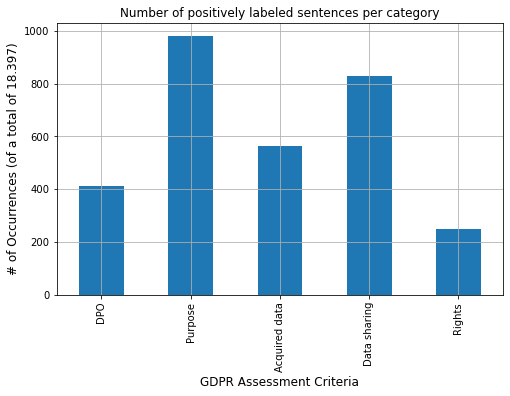

In [3]:
import matplotlib.pyplot as plt

categ = list(dataset.columns)[1:] # select all except 'text' column

counts = []
for column in categ:
#     print(dataset[column].value_counts())
    tmp_count = dataset[column].value_counts()
    # make a list of tuples that contain column name and number of pos labeled sentences     
    counts.append((column, tmp_count[1]))

df_stats = pandas.DataFrame(counts, columns=['GDPR_criteria', 'number_of_pos_sen'])

df_stats.plot(x='GDPR_criteria', y='number_of_pos_sen', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of positively labeled sentences per category")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('GDPR Assessment Criteria', fontsize=12)

#### What is the number of multi-labeled sentences?
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of GDPR criteria')

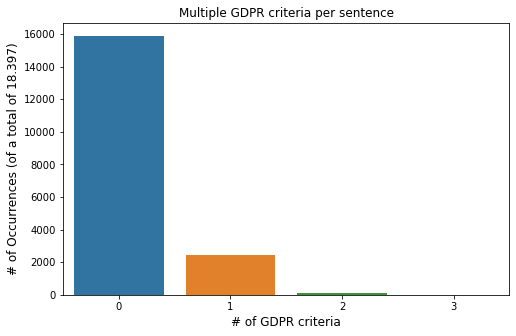

In [4]:
import seaborn as sns
rowsums = dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple GDPR criteria per sentence")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('# of GDPR criteria', fontsize=12)

- The vast majority of the sentences is not labeled at all (almost 16.000)

#### Class imbalance, possible solutions:
- oversampling minority class
    - Resample function from scikit-learn packaged: randomly duplicate examples in the minority class.
    - generating synthetic samples using SMOTE functionality in Imblearn package
- undersampling majority class

##### Oversampling should be done on the training set only:
In class imbalance settings, artificially balancing the test/validation set does not make any sense: these sets must remain realistic, i.e. you want to test your classifier performance in the real world setting, where, say, the negative class will include the 99% of the samples, in order to see how well your model will do in predicting the 1% positive class of interest without too many false positives. Artificially inflating the minority class or reducing the majority one will lead to performance metrics that are unrealistic, bearing no real relation to the real world problem you are trying to solve.

Max Kuhn, creator of the caret R package and co-author of the (highly recommended) Applied Predictive Modelling textbook, in Chapter 11: Subsampling For Class Imbalances of the caret ebook:

__You would never want to artificially balance the test set; its class frequencies should be in-line with what one would see “in the wild”.__

Re-balancing makes sense only in the training set, so as to prevent the classifier from simply and naively classifying all instances as negative for a perceived accuracy of 99%.

Hence, you can rest assured that in the setting you describe the rebalancing takes action only for the training set/folds._

sources: 
- https://imbalanced-learn.org/stable/over_sampling.html
- https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493


#### Oversampling

In [141]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
      
def oversample_data(x, y):    
    oversample = RandomOverSampler(sampling_strategy='minority')
    x_over, y_over = oversample.fit_resample(x, y)
    return x_over, y_over

# print(Counter(y))

#### Preprocessing

In [134]:
from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with numbers in them
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    
    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

In [136]:
print("Before preprocessing: ")
print(dataset['Text'].to_list()[0:3])
print()
print("Post preprocessing: ")
print(preprocessing(dataset['Text'].to_list()[:3]))

Before preprocessing: 
['this is a privacy statement disclosing our information gathering, use and dissemination practices for the company_04614 web site.', 'any other information that we gather, in pursuance of the unpaid fee, including    information that is shared by you with us.', 'in such circumstances we will continue to send you service related communications which are non-marketing where necessary.']

Post preprocessing: 
['thi is a privaci statement disclos our inform gather use and dissemin practic for the web site', 'ani other inform that we gather in pursuanc of the unpaid fee includ inform that is share by you with us', 'in such circumst we will continu to send you servic relat commun which are non-market where necessari']


## Feature engineering

#### TF-IDF
<img src="img/tfidfformula.png">


#### TF-IDF Vectorizer
Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- fit: ...
- transform: ...
- fit transform: ...

## Train model - Classification: Logistic Regression

For classification tasks, Logistic regression models the probabability of an event occurring (e.g., "DPO", "Purpose") depending on the values of the independent variables, which are categorical (in our case even binary: "DPO" is 1 or 0).

We know that z is the weighted sum of the evidence for the class (probability of the class occurring).<br>


\begin{align}
z = c_0+c_1*𝑥_1+c_2*𝑥_2+...+c_𝑛*𝑥_𝑛
\end{align}

The larger the weight the greater impact the given feature has on the final decision:<br>
- large positive values indicate a positive impact (for the event to occur)
- large negative values indicate a negative impact (for the event not to occur)

Z value is between -∞ and +∞. 
Therefore we apply the sigmoid (or logistic function) to this value to obtain prob. values between 0 and 1.
The final probability scores let the model predict the label. If the prob of "Red" is higher than all other labels, the prediction will be "Red".

More info: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

### Optimize parameters
___max_df___ float in range [0.0, 1.0] or int, default=1.0, is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

___min_df___ float in range [0.0, 1.0] or int, default=1, is used for removing terms that appear too infrequently. For example:
- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

__ngram_range___ tuple (min_n, max_n), default=(1, 1)
- The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.

___max_features___ int, default=None
- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

#### Split train and test set (using stratified split) 
- Split dataset into training, 10% (= 16557), and test set (1840)

Because we have multiple labels (5), we need to conduct the train_test_split an equal amount of time to maintain the stratify functionality for each and every label.

Info about stratified split in classification problems: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=Stratified%20Train%2DTest%20Splits,-One%20final%20consideration&text=As%20such%2C%20it%20is%20desirable,a%20stratified%20train%2Dtest%20split.

In [190]:
from sklearn.model_selection import train_test_split

train_text, test_text, train_dpo, test_dpo = train_test_split(dataset['Text'], dataset['DPO'], test_size=.1, 
                                                    random_state=42, stratify=dataset['DPO'])

x_train1, x_test1, train_purpose, test_purpose = train_test_split(dataset['Text'], dataset['Purpose'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Purpose'])

x_train2, x_test2, train_acquired_data, test_acquired_data = train_test_split(dataset['Text'], dataset['Acquired data'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Acquired data'])

x_train3, x_test3, train_data_sharing, test_data_sharing = train_test_split(dataset['Text'], dataset['Data sharing'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Data sharing'])

x_train4, x_test4, train_rights, test_rights = train_test_split(dataset['Text'], dataset['Rights'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Rights'])


train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
              test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]

train_test_text = [train_text, test_text, x_train1, x_test1, x_train2, 
              x_test2, x_train3, x_test3, x_train4, x_test4]

train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]
test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]

train_data_text = [element for i, element in enumerate(train_test_text) if i in [0, 2, 4, 6, 8]]
test_data_text = [element for i, element in enumerate(train_test_text) if i in [1, 3, 5, 7, 9]]


# if x_train5 == x_train2: 
#     print("same")

# train, test = train_test_split(dataset, test_size=0.1, random_state=42)

# train_text = preprocessing(train['Text'].to_list())
# test_text = preprocessing(test['Text'].to_list())

# train_dpo = train['DPO'].to_list()
# test_dpo = test['DPO'].to_list()

# train_purpose = train['Purpose'].to_list()
# test_purpose = test['Purpose'].to_list()

# train_acquired_data = train['Acquired data'].to_list()
# test_acquired_data = test['Acquired data'].to_list()

# train_data_sharing = train['Data sharing'].to_list()
# test_data_sharing = test['Data sharing'].to_list()

# train_rights = train['Rights'].to_list()
# test_rights = test['Rights'].to_list()

# train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
#               test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]


# test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]
# train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]

# len(train_test)

#### class distribution after stratified split

In [191]:
import collections 
# print((collections.Counter(train_data[0])))
# print((collections.Counter(test_dpo)))

for idx, ct in enumerate(categ):
    print(ct)
    
    print((collections.Counter(train_data[idx])))
    print((collections.Counter(test_data[idx])))


# frequency_calculated = ({'DPO training (1)':1, 'DPO 1':3, 'C':1, 'D':2, 'E':1, 'F':3, 'G':2})
# plt.bar(frequency_calculated.keys(), frequency_calculated.values())

DPO
Counter({0: 16184, 1: 373})
Counter({0: 1799, 1: 41})
Purpose
Counter({0: 15675, 1: 882})
Counter({0: 1742, 1: 98})
Acquired data
Counter({0: 16049, 1: 508})
Counter({0: 1783, 1: 57})
Data sharing
Counter({0: 15810, 1: 747})
Counter({0: 1757, 1: 83})
Rights
Counter({0: 16331, 1: 226})
Counter({0: 1815, 1: 25})


#### Optimize parameters
We optimize paramaters (ngrams) on the training set to avoid overfitting.

In [192]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler
from time import time

In [193]:
# 'UR_explicitly_mentioned' weggelaten
# categories = ['Purpose']
# prep_dataset = preprocessing(pps = dataset['Text'].to_list())
x_train = preprocessing(train_text)
x_test = preprocessing(test_text)


for i, category in enumerate(categ):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
#         'tfidf__min_df': (.05, .1, .15, .2), #best solution: (.75)
#         'tfidf__max_df': (0.75, .85), #best solution: (1.)
#         'tfidf__max_features': (None, 5000, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), #best solution: (1,2)
    }

    y_train = train_data[i]

    grid_search = GridSearchCV(tfidf_pipeline, parameters)

    print("Performing grid search for label: {}".format(category))
    print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search for label: DPO
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 45.906s

Best score: 0.983
Best parameters set:
	tfidf__ngram_range: (1, 1)
Performing grid search for label: Purpose
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 38.438s

Best score: 0.947
Best parameters set:
	tfidf__ngram_range: (1, 1)
Performing grid search for label: Acquired data
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 37.993s

Best score: 0.969
Best parameters set:
	tfidf__ngram_range: (1, 1)
Performing grid search for label: Data sharing
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 44.300s

Best score: 0.955
Best parameters set:
	tfidf__ngram_range: (1, 1)
Performing grid s

# Predict & Evaluate
Using optimized parameters

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import pickle

In [209]:
# prep_text = preprocessing(pps = dataset['Text'].to_list())
# x_train = train_text 
# x_test = test_text

# params = [(1,1), (1,2), (1,1), (1,1), (1,1)] # stemming + stopwords + ngrams
params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams
# params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # lemmatizing + ngrams


for i, category in enumerate(categ):
    print("Label in progress:" + category)
    print()
    
    # initalise the vectorizer 
#     vectorizer = TfidfVectorizer(max_df = .75, min_df = .05, ngram_range = (1,2))
    vectorizer = TfidfVectorizer(ngram_range = params[i])
    print("Ngram:", params[i])

    x_train = preprocessing(train_data_text[i])
    x_test = preprocessing(test_data_text[i])
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    y_train = train_data[i]
    y_test = test_data[i]

    x_train, y_train = oversample_data(x_train, y_train)
    
    # Make an instance of the Model
    # all parameters not specified are set to their defaults
    lr = LogisticRegression()

    # Train the model on the data, storing the information learned from the data
    # Model is learning the relationship between digits (x_train) and labels (y_train)
    
    lr.fit(x_train, y_train)
        
    # Save to file in the current working directory
    lr_file = "linreg-oversampling-" + category + ".pkl"
    with open(lr_file, 'wb') as file:
        pickle.dump((vectorizer, lr), file)
    
    
    # Let's see what are the possible labels to predict (and in which order they are stored)
    print(lr.classes_)

    # We can get additional information about all the parameters used with LogReg model
    print(lr.get_params())

    y_pred = lr.predict(x_test)
    
    words = vectorizer.get_feature_names()

    print()
    print("Most important features:")
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()
        print()
        
    
    print()
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("TFIDF ROC_AUC Score", roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
    
    print("----------------------------------")
    print()

Label in progress:DPO

Ngram: (1, 1)
[0 1]
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Most important features:
0
contact 7.328372318973588
pleas 7.113049411390763
offic 7.021611529458203
control 6.650809430766423
should 6.384675591691125
at 6.209474359579944
ico 6.072650325825969
email 6.060406463758473
post 5.826060116207886
telephon 5.805852918382683
...
INTERCEPT:-4.474140058902366
...
it -2.8176480162559323
give -2.8226723638033167
phone -3.0187088609356736
account -3.024175411224925
other -3.362254114062454
name -3.5085258259000174
not -3.7385382385376866
cooki -3.92341479472577
servic -3.9762340470431337
includ -4.2133097286934875



Confusion matrix:
[[1733   66]
 [   8   33]]

Classification report:
              precision    recall  f1-score   su

### Background: performance metrics

### Accuracy ### 
For label X, precision is the number of correctly predicted labels divided by all labels<br>

\begin{align}
Precision(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made} = \frac{true\ positives\ +\ true\ negatives}{true\ positives\ +\ false\ positives\ +\ true\ negatives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>
true negative = correctly predicted as not label A<br>
false negative = predicted as another label, whereas it is actually label A

- ___Is not very helpful in case of class imbalance (classifying everything to the majority class will result in this case in a good accuracy)___


### Precision ### 
For label X, precision is the number of correctly predicted labels __out of all predicted labels__ (for the actual label X) (What percent of the predicted labels are correct? The focus is on predictions.).<br>

\begin{align}
Precision(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made\ as\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ positives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>

### Recall ### 
For label X, recall is the number of correctly predicted labels (same as above) __out of the number of actual labels A__ (Out of all actual label A's, what percent of them did the model predict correctly? The focus is on actual labels.).<br>
In other words: r = true positives / (true positives + false negatives)

\begin{align}
Recall(r) = \frac{correctly\ predicted\ as\ label\ A}{all\ actual\ items\ with\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false negative = predicted as another label, whereas it is actually label A

### F1 Score ###
Ok so precision and recall measures the performance of a model from two different perspectives.
We can combine the two measures to get a single, balanced score, which is also called __F1 score__.
Obtaining a single score is often easier to compare different models.

\begin{align}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall} \\
\end{align}


### Area Under the Curve (AUC) ###
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
_The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes._
- When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. 
- If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.
- When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values.
- When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points

Source: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

### Classification report ###
- __macro avg__: Calculate precision, recall and f1 metrics for each label, and find their average. This does not take label imbalance into account: f1 scores are averaged (with equal weights)
- __weighted avg__: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters "macro" to account for label imbalance (it can result in an F-score that is not between precision and recall).

### Confusion matrix ###

| |Actual|label|
|---|---|---|
|Predicted| TN | FP |
|label| FN | TP |

## Evaluate

#### Performance (Logistic Regression)
|Label|Approach|Precision|Recall|F1|AUC|
|---|---|---|---|---|---|
|DPO|stemming + stopwords removal + ngram(1,1)|0.81 (0.98)|0.67 (0.97)|0.72 (0.98)|0.973|
|DPO|stemming + ngram(1,1)|0.79 (0.98)|0.68 (0.98)|0.72 (0.98)|0.977|
|DPO|oversampling + stemming + ngram(1,1)|0.67 (0.98)|0.88 (0.96)|0.73 (0.97)|0.980|
|Purpose|stemming + stopwords removal + ngram(1,2)|0.88 (0.95)|0.60 (0.95)|0.65 (0.94)|0.943|
|Purpose|stemming + ngram(1,2)|0.83 (0.94)|0.61 (0.95)|0.66 (0.94)|0.936|
|Purpose|oversampling + stemming + ngram(1,2)|0.65 (0.95)|0.86 (0.90)|0.70 (0.92)|0.934|
|Acquired data|stemming + stopwords removal + ngram(1,1)|0.96 (0.98)|0.63 (0.98)|0.70 (0.97)|0.931|
|Acquired data|stemming + ngram(1,1)|0.93 (0.97)|0.63 (0.98)|0.70 (0.97)|0.942|
|Acquired data|oversampling + stemming + ngram(1,1)|0.64 (0.97)|0.79 (0.94)|0.69 (0.95)|0.930|
|Data sharing|stemming + stopwords removal + ngram(1,1)|0.87 (0.96)|0.67 (0.97)|0.73 (0.96)|0.970|
|Data sharing|stemming + ngram(1,1)|0.87 (0.96)|0.70 (0.97)|0.75 (0.96)|0.973|
|Data sharing|oversampling + stemming + ngram(1,1)|0.75 (0.97)|0.93 (0.96)|0.81 (0.96)|0.975|
|Rights|stemming + stopwords removal + ngram(1,1)|0.95 (0.99)|0.68 (0.99)|0.75 (0.99)|0.992|
|Rights|stemming + ngram(1,1)|0.95 (0.99)|0.70 (0.99)|0.78 (0.99)|0.993|
|Rights|oversampling + stemming + ngram(1,1)|0.77 (0.99)|0.95 (0.99)|0.84 (0.99)|0.996|


#### Notes:
|DPO (1799N, 41P)| Predicted N | Predicted P | | Predicted N | Predicted P |
|---|---|---|---|---|---|
| Actual N | 1789 | 10 | -> | 1733 | 66 |
| Actual P | 26 | 15 | -> | 8 | 33 |

- precision drops after oversampling
    - this is due the increase of false positives
- recall increases after oversampling
    - due to the decrease of false negatives 


#### Most important features 
|DPO|Purpose|Acquired data|Data sharing|Rights|
|---|---|---|---|---|
|offic| purpos | name | shar | delet |
|email| use person | address | disclos | correct |
|pleas| follow purpos | photograph | sell | erasur |
|contac| order | detail | pass | eras |
|question| servic | record | never | remov |
|write| may use | correct | transfer | right |
|protect| data follow | health | third | rectif |
|us| interest | number | parti | forgotten |
|control| use inform | sensit | outsid | rectifi |
|mail| use | includ | compani | request |

## Predict collected dataset of scraped SME policies

In [176]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
  
scores_sme = numpy.zeros((5, 1000))    
    
# use glob to get all the csv files 
# in the folder
path = 'data\SME'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
print(len(csv_files))  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j)
    
    df_sme = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_sme)
    sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]

    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = sme_test_data[i]
        y_pred = lr.predict(x_test)

        if 1 in y_pred:
            index_int = list(y_pred).index(1)
            print(index_int)
            print(category)
            print(test_text[index_int])
            print(1)
            
            print(i, j)
            scores_sme[i][j] = 1
            print()

#         print("")
#         print("")
#         print("")

1000
This is file:  0
4
Acquired data
also, we inform you that this website will record your browsing of the same when you fill in and send the contact form.
1
2 0

This is file:  1
10
Purpose
other portions of the site require personal information in order for you to complete certain activities such as joining american mensa, renewing your membership, updating your member profile and so on.
1
1 1

10
Acquired data
other portions of the site require personal information in order for you to complete certain activities such as joining american mensa, renewing your membership, updating your member profile and so on.
1
2 1

This is file:  2
17
DPO
when you use our contact form or shopfinder  3.2.1
1
0 2

7
Purpose
the data we collect, the purpose and the legal basis for processing  3.1
1
1 2

18
Acquired data
if you complete a contact form or book an appointment, or when you use our shopfinder to make an appointment request or an enquiry with a specific hearing care professional we will pr

3
Purpose
it also describes the choices available to you regarding our use of your personal information and how you can access and update this information.  
1
1 12

14
Acquired data
information collection and use  cornerstone information systems companies may collect personally identifiable information (“pii”)
1
2 12

8
Data sharing
cornerstone information systems companies are responsible for the processing of personal data it receives, under the privacy shield framework, and subsequently transfers to a third party acting as an agent on its behalf.
1
3 12

65
Rights
we provide a way to correct, update or remove that user’s personal data provided to us.
1
4 12

This is file:  13
21
DPO
if you believe that any information we are holding on you is incorrect or incomplete, please write to or email us.
1
0 13

9
Purpose
we use the device information that we collect to help us screen for potential risk and fraud (in particular, your ip address), and more generally to improve and optimize o

103
DPO
you may contact us regarding any questions or comments regarding this privacy policy by emailing us at episode.app+privacy@gmail.com.
1
0 24

12
Purpose
information collected and used  
1
1 24

3
Acquired data
personal information can include, for example, an individual’s first and last name, address, telephone number, e-mail address or credit card number.
1
2 24

28
Data sharing
platforms/third-party marketplaces  
1
3 24

102
Rights
changing or deleting your information  
1
4 24

This is file:  25
35
DPO
you may contact us anytime if you have any questions about our policies, your information, or if you wish to make a complaint or withdraw your consent under this policy.
1
0 25

1
Purpose
the sud group (“sud group”, “we”, “us” or “our”) values your business and is committed to ensuring you are informed about our practices and policies regarding information that is processed in the delivery of our services to you via the “the sud group” website (the “website”).  
1
1 25

9
Acq

10
Purpose
we potentially process your personal information when you:  visit our offices, surf our websites, use our apps, attend our events, ...  
1
1 35

23
Acquired data
what personal information do we collect?  
1
2 35

79
Data sharing
who has access to your personal information?  
1
3 35

89
Rights
we will delete your personal information if it is no longer needed, has no more relevance, or is simply outdated.  
1
4 35

This is file:  36
1
DPO
the protection of your personal data is of particular concern to us.
1
0 36

14
Purpose
furthermore, the following data are stored for the purpose of contract processing: name, address, billing address, delivery address, telephone number, e-mail address, articles ordered, invoices, delivery notes, credit notes.  
1
1 36

5
Acquired data
insofar as we gather personal data (for example, name, address, or e-mail addresses) on our website, this is done on a voluntary basis whenever possible.
1
2 36

6
Data sharing
these data will not be shared w

3
Purpose
to ensure you can make informed decisions and feel confident about supplying personal data relating to you when purchasing our products and using our services, we provide this policy statement outlining our data collection practices and the choices you have concerning how the data is being collected and used.  
1
1 47

5
Acquired data
it can include, among other things, your name, contact number, address, age, gender, passport or other identification document details, driver’s licence details, personal financial information, frequent flyer or travel partner information.  
1
2 47

40
Data sharing
data will not be shared with third parties for their own marketing purposes.  
1
3 47

This is file:  48
3
DPO
magic f+c hungary kft (hereinafter referred to as: data controller)  address of data controller:
1
0 48

30
Purpose
this service may use cookies in order to collect information and prepare a report from the statistical data that refer to the use of the website without identif

9
Data sharing
we collect your data as a result of your sharing of your data with us.
1
3 59

19
Rights
you also have the right to demand that your data are rectified, blocked or eradicated.
1
4 59

This is file:  60
1
DPO
: 05279208, with registered office at karlovo náměstí 290/16, nové město, 120 00
1
0 60

23
Purpose
this information is used by it servis for the operation of the service, to maintain quality of the service, and to provide general statistics regarding use of the it servis web site.  
1
1 60

19
Acquired data
collection of your personal information  it servis collects personally identifiable information, such as your e-mail address, name, home or work address or telephone number.
1
2 60

31
Data sharing
it servis does not sell, rent or lease its customer lists to third parties.
1
3 60

58
Rights
these include, under certain circumstances, the right to:  request access to your personal data: you have the right to obtain a copy of the personal data we hold about you and

70
Rights
access to, or updates to personal data  
1
4 67

This is file:  68
0
Purpose
policy for the processing of personal data  pursuant to articles 13 and 14 of the gdpr 679-2016 defined as "general data protection regulation" we inform you that the personal data you provided us in the context of our business activity, aimed solely at fulfilling contractual obligations and complying to specific requests related to the management of customary business relations and, more specifically, the compilation of personal data registers, storing of client/supplier accountancy, invoicing, sending hard copy or digital communications and for internal use related to statistics and market research, will be processed manually and/or digitally also with the use of computerized procedures at the getech s.r.l. offices located in via cà dell’orbo nord, 17/2 –
1
1 68

27
Data sharing
2.where personal data are transferred to a third country or to an international organisation, the data subject shall have

4
Acquired data
the following definitions of terms used in this document are drawn from article 4 of the european union’s general data protection regulation:  personal data: any information relating to an identified or identifiable natural person (“data subject”) who can be identified, directly or indirectly, in particular by reference to an identifier such as a name, an identification number, location data, an online identifier or to one or more factors specific to the physical, physiological, genetic, mental, economic, cultural or social identity of that natural person.  
1
2 79

8
Data sharing
data controller: the natural or legal person, public authority, agency or any other body, which alone or jointly with others, determines the purposes and means of the processing of personal data.  
1
3 79

47
Rights
when acting as a data controller, dpo is responsible to provide data subjects with a reasonable access mechanism to enable them to access their personal data, and must allow them t

17
Rights
right of correction  
1
4 86

This is file:  87
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 87

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 87

5
Acquired data
what kinds of information do we collect?  
1
2 87

32
Data sharing
how is this information shared?  
1
3 87

51
Rights
inspection and correction  
1
4 87

This is file:  88
70
DPO
for any questions you may have about the management of your personal data, you can send your request or complaint directly to us at honotel développement sas, 20 rue treilhard, 75008 paris or by e-mail at contact@honotel.fr.  
1
0 88

0
Purpose
when you use the https://www.hotelcervantesparis.com/ website, happyculture may have to gather and manage your personal data, either by itself or in collaboration with other establishments that are members of the honotel hotel network or the service programme known as happyculture, enabling

30
Data sharing
in other sections of the website, you are asked to submit personal data related to third parties, such as other contact persons in your company or your relatives who are employees of aramex.  
1
3 97

115
Rights
data subjects’ rights  under the regulation, you, as a data subject, are entitled to exercise the following rights before aramex, at any time:  access your personal data being processed by aramex (and/or a copy of that personal data), as well as information on the processing of your personal data;  correct·or update your personal data processed by aramex, where it may be inaccurate or incomplete;  request erasure of your personal data being processed by aramex, where you feel that the processing is unnecessary or otherwise unlawful;  request
1
4 97

This is file:  98
54
DPO
you are entitled to having your personal data deleted by requesting this to exicom software.
1
0 98

29
Purpose
we use our own products, and products of third parties acting on our behalf, to

51
Data sharing
do we share your data?  
1
3 108

22
Rights
the right to rectification if any personal data we hold about you is inaccurate or incomplete (please contact us using the details in section 14);  4.1.4
1
4 108

This is file:  109
5
DPO
if you have any questions or concerns, do not hesitate to contact us by email at info@bolzonelladivise.com .  
1
0 109

7
Purpose
the purpose of this statement is to provide more information about the processing of information of the users who use the services accessible from the websites bolzonelladivise.com.it and castbolzonella.it.
1
1 109

26
Acquired data
the data in our possession, obtained by contractual or precontractual relationships, have been collected directly from the data subject both in paper and digital form.  
1
2 109

24
Data sharing
outside of the cases indicated above, your personal data will not be diffused and communicated to third parts, except through your estimate and explicit consent.  
1
3 109

47
Rights
successivel

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 121

5
Acquired data
what kinds of information do we collect?  
1
2 121

32
Data sharing
how is this information shared?  
1
3 121

51
Rights
inspection and correction  
1
4 121

This is file:  122
46
DPO
if you would like to use one of these rights, please contact us at privacy@vormats.com  
1
0 122

0
Purpose
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
1 122

0
Acquired data
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
2 122

14
Data sharing
if we would like to use your personal data for any other purposes than those listed in this statement, we can only do so if thi

5
Purpose
for certain services or activities you will need to provide personal data for us to be able to provide you the requested service or product or for you to participate in the activity.
1
1 131

10
Acquired data
you will be asked to provide your name and email address and obviously information about your request.
1
2 131

39
Data sharing
how we share your personal data  
1
3 131

68
Rights
your rights to access, rectification, deletion, restriction and data portability  
1
4 131

This is file:  132
14
DPO
if you visit other website by clicking links on this website, please read the privacy statement of the site you are visiting, to know how your personal data is processed.
1
0 132

19
Purpose
personal data  thirona uses the information you provide for several purposes based upon the reason for you to contact us.
1
1 132

21
Acquired data
we may also use personal data you provide us to maintain a business relationship with you after your first enquiry.
1
2 132

51
Data sharing
go

0
Acquired data
this site collects some personal data from its users.
1
2 140

14
Data sharing
the user assumes the responsibility of the personal data of third parties obtained, published or shared through this application and guarantees to have the right to communicate or disseminate them, freeing the owner from any responsability to third parties.  
1
3 140

56
Rights
the subjects to whom the personal data refer have the right at any time to obtain confirmation of the existence of any personal data from the data controller, to know its content and origin, to verify its accuracy or request its integration, deletion, updating, rectification, transformation into anonymous form, or blocking of personal data processed in violation of the law, as well as to oppose in any case, for legitimate reasons, to their processing.
1
4 140

This is file:  141
40
DPO
if you feel that we are not abiding by this privacy policy, you should contact us immediately via telephone at (941) 795 – 2800 or via 

32
Purpose
these companies may use your personal information to help irriga system® communicate with you about offers.
1
1 152

13
Acquired data
personal information means any information that may be used to identify an individual, including, but not limited to, a first and last name, a home or other physical address, phone and an email address, or other contact information like cookies and other tracking technologies.  
1
2 152

20
Data sharing
third party services  irriga system
1
3 152

This is file:  153
11
DPO
if you do not want us to use your personal data to market to you by email and/or sms or pass on your details to third parties for marketing purposes, please, unsubscribe by using the link in the relevant email.
1
0 153

8
Purpose
this data allows us:  to carry out our obligations arising from any contracts entered into between you and us including delivery of product, invoicing and reporting; andto provide you with information on products and/or services you specifically req

6
Data sharing
with whom do we share your personal data?  
1
3 162

74
Rights
where it is no longer required to retain personal data, we erase or anonymize your personal data.  
1
4 162

This is file:  163
70
DPO
to manage your requests: to attend and manage your requests to us.  
1
0 163

2
Purpose
we use your personal data to provide and improve the service.
1
1 163

21
Acquired data
collecting and using your personal data  types of data collected  personal data  
1
2 163

17
Data sharing
it refers to third-party companies or individuals employed by the company to facilitate the service, to provide the service on behalf of the company, to perform services related to the service or to assist the company in analyzing how the service is used.  
1
3 163

95
Rights
for services where your data is not publicly displayed, upon deletion of your account, associated data as provided by you and the account itself are immediately and irrecoverably deleted.  
1
4 163

This is file:  164
10
DPO
su

14
Rights
you may request details of the personal information that we hold about you.
1
4 173

This is file:  174
59
DPO
the client can see and update the majority of his data online or by contacting us directly at privacy@luxuryofhomes.com.  
1
0 174

13
Purpose
other personal data (mostly personal details, email address, address, phone number) are necessary for us in order to elaborate a quote and to place the order of the products and/or services chosen by the client.
1
1 174

7
Acquired data
we selects different types of personal data of our clients e.g.: • personal data of the client (name, email, full address, phone number, nationality, residence and/or domicile and other personal data) given by the client himself during the registration process on our website, as well as at the moment of the registration for our newsletter or the creation of a new account on our website.
1
2 174

12
Data sharing
the clients does not have any obligation to share this personal data.
1
3 174

57
Ri


33
Acquired data
a real-time anti-fraud verification system for payments, when a purchase is carried out on the site: this processing includes the communication of some personal data (specifically your name, surname, postal address, ip address, telephone number, e-mail address, bank identification, contents of the cart and user agent information, namely browser and language settings) to maxmind inc., a company specialized in anti-fraud services which provides a fraud score to the purchase based on the automated processing of personal data disclosed by the company.
1
2 182

18
Data sharing
only with regard to certain services, the data may be processed for disclosing to third parties for their marketing purposes, namely to provide you with information and/or to propose offers on products, services or initiatives offered or promoted by other companies of the register group and/or its affiliates and/or subsidiaries and/or other business partners and outsourcers who act as independent dat

6
Purpose
we may collect and process the following personal information:  name and other identifiable information  
1
1 192

6
Acquired data
we may collect and process the following personal information:  name and other identifiable information  
1
2 192

23
Data sharing
information you share with us  
1
3 192

41
Rights
you can view, modify and / or delete your online success profile at any time via this link.  
1
4 192

This is file:  193
29
Acquired data
full name and address of the exporter  full name and address of consignee  full name and address of the agent/freight forwarder,
1
2 193

75
Data sharing
note that if the product to be shipped contains component parts manufactured in another country, the u.s. company must obtain signatures of the relevant chambers in those countries and have the document legalized by the argentine consulates in those countries.
1
3 193

This is file:  194
4
DPO
data processors of leinonen group are:  - leinonen oü, registered address at põhja puiest

13
Purpose
generally, we only collect and use your personal data to the extent necessary to provide our services.
1
1 203

13
Acquired data
generally, we only collect and use your personal data to the extent necessary to provide our services.
1
2 203

19
Data sharing
tank & rast transmits personal data to third parties only if and to the extent this is necessary for performing a contract or for billing purposes (the legal basis for the transmission in this case is art.
1
3 203

44
Rights
the data will be deleted as soon as it is no longer necessary to achieve the purpose for which it was collected.
1
4 203

This is file:  204
11
DPO
how to contact us  
1
0 204

18
Purpose
we also collect information when you voluntarily complete customer surveys, provide feedback and participate in competitions.
1
1 204

7
Acquired data
what information do we collect about you?  
1
2 204

22
Data sharing
if you agree, we shall pass on your personal information to our partners so that they may offer you

1
1 214

0
Acquired data
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
2 214

14
Data sharing
if we would like to use your personal data for any other purposes than those listed in this statement, we can only do so if this is in line with the purpose(s) for which we have initially collected your personal data.
1
3 214

13
Rights
we archive your profile for 24 months to make it possible to restore deleted items that shouldn’t have been deleted or for example to re-activate your account if you left the service for a while.  
1
4 214

This is file:  215
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 215

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 215

5
Acquired data
what kinds of information do we collect?  
1
2 215

3

48
Data sharing
personal information sharing  
1
3 225

72
Rights
to the extent provided by the law of your jurisdiction, you may have the right to (1) access certain personal information we process about you and request details of that processing; (2) request that we update, correct, amend, erase, or restrict your personal information or
1
4 225

This is file:  226
3
Purpose
we may share this information to better understand your financial needs and to provide products and services we believe may interest you.  
1
1 226

0
Data sharing
under certain circumstances, your personal information including some or all of the categories of information set out under “what information we collect” is shared and may have been shared among rbc companies or other third parties in the past 12 months.  
1
3 226

This is file:  227
16
DPO
the person responsible for data management is mrs. rossana ferrari, who for the purposes of his / her task is available at the registered office of the company that 

7
DPO
for your protection, we are registered under the general data protection regulation and have given all appropriate notifications to the information commissioners office.  
1
0 238

9
Purpose
we will also ask for your consent to provide us with your personal or professional interests, demographics, experiences with our products, and contact preferences in order to provide you with further correspondence about our products and services.    
1
1 238

8
Acquired data
prior to supplying information about vehicles or services, we will collect the following information:  name  telephone number  email address    
1
2 238

14
Data sharing
do we do with the information
1
3 238

25
Rights
if you believe that any information we are holding on you is incorrect or incomplete, please write or e-mail us as soon as possible to the above address.    
1
4 238

This is file:  239
10
DPO
if there is no means, contact privacy@tsia.com, write to the address provided below, or call tsia to opt out.
1
0 


52
Acquired data
the information stored there can be recorded, collected and evaluated by google inc. or third parties.  
1
2 247

6
Data sharing
only in exceptional cases will the full ip address be transmitted to a google server in the usa where it will be shortened.
1
3 247

204
Rights
your data that we have received in the course of contacting you will be deleted as soon as it is no longer required to achieve the purpose for which it was collected, your request has been fully processed and no further communication with you is necessary or desired by you.  
1
4 247

This is file:  248
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 248

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 248

5
Acquired data
what kinds of information do we collect?  
1
2 248

32
Data sharing
how is this information shared?  
1
3 248

51
Rights
inspection and correction  
1
4 248

This is file:  249

37
Data sharing
we may also contract with a third party to send an e-mail to our registered users/members.  
1
3 258

84
Rights
how can a user access, change, and/or delete personal information?  
1
4 258

This is file:  259
63
DPO
you also have the right to request amendments to your personal data or profile, or to correct or remove your personal data.
1
0 259

4
Purpose
we ask for permission when processing personal data that are used for marketing purposes.
1
1 259

1
Acquired data
spa sport hotel zuiver may/can process the following personal data:  your first name and surname  
1
2 259

31
Data sharing
does spa sport hotel zuiver share my personal data with third parties?  
1
3 259

28
Rights
you reserve the right to request that your personal data is removed.
1
4 259

This is file:  260
15
DPO
personal and contact details:  
1
0 260

1
Purpose
in this page we describe how to manage the web site in relation to processing the personal data for privacy policy.  
1
1 260

3
Acquired d

2
Data sharing
our corporate privacy  the company's officers, management, and members of staff shall, at all times, respect the confidentiality of and endeavor to keep safe any and all personal data collected and/or stored and/or transmitted and/or used for, or on behalf of, the company.
1
3 270

4
Rights
where an individual legitimately requests access to and/or correction of personal data relating to the individual, held by the company, then the company shall provide and/or correct that data in an appropriate time and manner.  
1
4 270

This is file:  271
72
DPO
a right to object to processing: you have the right to request that we stop processing personal data about you (for example, when your personal data is processed for direct marketing purposes, you have the right to object to the processing of such data at any time by writing to privacy@lsac.org or clicking on the “unsubscribe” link available at the bottom of the messages received).  
1
0 271

12
Purpose
information about your

30
Acquired data
this policy is not applicable to any information collected offline or via channels other than this website.  
1
2 280

This is file:  281
48
DPO
if you are a parent or guardian and you are aware that your children has provided us with personal data, please contact us.
1
0 281

5
Purpose
this page informs you of our policies regarding the collection, use, and disclosure of personal data when you use our service and the choices you have associated with that data. .  
1
1 281

1
Acquired data
address of registration:  43
1
2 281

32
Data sharing
your information, including personal data, may be transferred to — and maintained on — computers located outside of your state, province, country or other governmental jurisdiction where the data protection laws may differ than those from your jurisdiction.  
1
3 281

110
Rights
you can request that we erase any personal data we hold about you (even though we do not hold any).
1
4 281

This is file:  282
19
DPO
if you complete a c

124
Rights
other data protection rights  rectification of inaccurate personal data;  erasure of personal data (also known as the “right to be forgotten”);  
1
4 291

This is file:  292
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 292

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 292

5
Acquired data
what kinds of information do we collect?  
1
2 292

32
Data sharing
how is this information shared?  
1
3 292

51
Rights
inspection and correction  
1
4 292

This is file:  293
27
DPO
(contact us) below.  
1
0 293

2
Purpose
categories of personal data and processing purposes  metadata  you may use our website or app without providing any personal data about you.
1
1 293

2
Acquired data
categories of personal data and processing purposes  metadata  you may use our website or app without providing any personal data about you.
1
2 293

16
Data sharing
third parties  transfer to ser

11
Data sharing
in addition, the data protection procedure is approved by european data protection authorities as a basis for transferring personal data from hydro companies established within the european economic area ("eea") to hydro companies established outside the eea.  
1
3 303

68
Rights
you may also request that any excessive personal data we may happen to process is deleted or blocked, and request rectification of any wrongful personal data that we may process.
1
4 303

This is file:  304
6
DPO
the data controller is samap srl, castel goffredo (mn), via raffaello sanzio 2/3, castel goffredo (mn), italy; e-mail [email protected], pec: [email protected], telephone 0376 779169.  
1
0 304

12
Purpose
these data are necessary to use web-based services and are also processed in order to  extract statistical information on service usage (most visited pages, visitors by time/date, geographical areas of origin, etc.);  check functioning of the services.  
1
1 304

9
Acquired data
cate

4
DPO
for detailed information about the subject matter of data protection, please consult our data protection declaration, which we have included beneath this copy.  
1
0 314

10
Purpose
this may, for instance be information you enter into our contact form.  
1
1 314

5
Acquired data
data recording on this website  
1
2 314

9
Data sharing
we collect your data as a result of your sharing of your data with us.
1
3 314

19
Rights
you also have the right to demand that your data are rectified or eradicated.
1
4 314

This is file:  315
47
DPO
contacting us  please do not hesitate to contact us regarding any matter relating to this privacy policy at starlight promotions, email: office@starlight-promotions.com    
1
0 315

2
Purpose
in running and maintaining our website we may collect and process the following data about you:  1.
1
1 315

1
Acquired data
information we collect  
1
2 315

27
Data sharing
where your consent has been provided in advance we may allow selected third parties to 

11
Purpose
we need to collect personal information to provide the requested services to you.
1
1 325

4
Acquired data
collectively, we refer to the snc sites, social media pages, emails, and offline business interactions as the “services.”  
1
2 325

10
Data sharing
we receive your personal information from other sources, for example: publicly available databases; our third party sellers; joint marketing partners, when they share the information with us.    
1
3 325

107
Rights
how you can access, change, or delete your personal information  
1
4 325

This is file:  326
2
DPO
as defined by the basic eu data protection regulations, onesails international srl (hereinafter referred to as "osi" and/or "we" and/or "us") with registered offices in i-37126 verona (vr), via isonzo, 11 - e-mail: privacy@onesails.com is responsible for the processing of your personal data.    
1
0 326

4
Purpose
if you have any questions regarding the use of your personal data use the following contact data:  e-

4 333

This is file:  334
13
DPO
2016/679, we are the data controller.
1
0 334

26
Purpose
when you make a booking from our booking engine;  financial details in order to process your booking when we require pre-payment;  details of transactions you carry out through our booking engine and details of the fulfilment of your orders.  
1
1 334

24
Acquired data
personal data we collect and process  
1
2 334

29
Data sharing
we grant permission to our data processor:  to use your personal information for reserving rooms and/or other services for you at new aegli hotel poros ;  ; to pass on your financial details to new aegli hotel poros and/or appropriate third party (for example, credit card company) for the purpose of confirming or paying for a booking;  and/or appropriate third party (for example, credit card company) for the purpose of confirming or paying for a booking; to use your information for marketing purposes (where you explicitly agree to this); and  to pre-complete forms and 

55
Rights
the medical export group b.v. aims to take reasonable steps to allow you to correct, amend, delete or limit the use of your personal data.  
1
4 346

This is file:  347
79
DPO
you have the right to object to the collection of this data by google by contacting google directly.
1
0 347

6
Purpose
the access data needs to be processed to make it possible for you to visit and operate our websites with ease and to ensure continuous functionality and security of our website.
1
1 347

9
Acquired data
it is not possible to directly deduce your identity from the information stored in the log files – in particular, we will only store the ip address in truncated, anonymised form.
1
2 347

32
Data sharing
if you do not agree with your message potentially being disclosed to another company or third party, please inform us directly in your message – naturally it would also be possible for you to do so as a precautionary measure.
1
3 347

This is file:  348
13
DPO
if you, as a user, disagre


58
Rights
you may object to the processing of your personal data for legitimate reasons and you may also request the correction or erasure of it.  
1
4 356

This is file:  357
101
DPO
avaya shall demonstrate compliance to the data controller.  
1
0 357

42
Purpose
when processing any personal data for purposes of carrying out avaya’s business activities, employment administration and supply chain management.
1
1 357

27
Acquired data
the types of such personal data typically include name, contact information (company, title / position, email address, phone number, physical address), connection data, location data, video / call (recordings) data, and metadata derived thereof, etc.
1
2 357

23
Data sharing
unless agreed otherwise or set out in a more specific privacy statement, in the course of business avaya will transfer personal data overseas to leverage its international resources, including affiliated companies and trusted third parties, for the purpose of providing requested solut

5
Acquired data
the personal data we process are the following: contact details, contract details, invoices, payment status and other subscription details.
1
2 368

19
Data sharing
we also share data about you with other companies in the group, when we or the other companies in the group have a legitimate interest of doing so, see examples in part 4.
1
3 368

This is file:  369
46
DPO
if you would like to use one of these rights, please contact us at privacy@vormats.com  
1
0 369

0
Purpose
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
1 369

0
Acquired data
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
2 369

14
Data sharing
if we would like to use your personal data

23
Data sharing
individuals within the organization may be involved in accessing data (such as: sales staff, marketing personnel, administrative staff, lawyers, it staff, etc.) and external parties (such as: postal couriers, transporters, internet service providers, it companies, communication agencies, technical service providers, etc.).  
1
3 376

This is file:  377
30
DPO
to find out what personal data we hold on you or to have your personal data updated, amended or removed from our database, please email us.  
1
0 377

14
Purpose
we use the non-personal data gathered from visitors to our website in order to get a better understanding of where our visitors are situated.
1
1 377

6
Acquired data
this is data that identifies you and can be used to identify or contact you and may include your name, address, email address, telephone number, job title and billing information.
1
2 377

19
Data sharing
we will not disclose your personal data or non-personal data to third parties unless you

This is file:  389
14
DPO
data subject data subject is any identified or identifiable natural person, whose personal data is processed by the controller responsible for the processing.  
1
0 389

92
Purpose
the controller no longer needs the personal data for the purposes of the processing, but they are required by the data subject for the establishment, exercise or defence of legal claims.
1
1 389

4
Acquired data
the processing of personal data, such as the name, address, e-mail address, or telephone number of a data subject shall always be in line with the general data protection regulation (gdpr), and in accordance with the country-specific data protection regulations applicable to the 1toall gmbh. by means of this data protection declaration, our enterprise would like to inform the general public of the nature, scope, and purpose of the personal data we collect, use and process.
1
2 389

21
Data sharing
recipient recipient is a natural or legal person, public authority, agency or 

This is file:  398
4
DPO
when emailing trustmoore, we will use your personal data to respond to your questions or comments.
1
0 398

4
Purpose
when emailing trustmoore, we will use your personal data to respond to your questions or comments.
1
1 398

7
Acquired data
we may also process personal data in order to comply with statutory requirements.
1
2 398

19
Data sharing
the information obtained is stored by google on servers in the united states.
1
3 398

25
Rights
to the degree it processes personal data as a controller within the meaning of the gdpr, you have the right to request trustmoore to: provide information about and access to your personal data  rectify your personal data  erase your personal data (“right to be forgotten”)  restrict processing of your personal data  object to the processing of your personal data  receive your personal data in a structured, commonly used and machine-readable format and to (have) transmit(ted) your personal data to another organization to exer

8
Data sharing
we will never lease, distribute or sell your personal information to third parties unless we have your permission or the law requires us to.  
1
3 409

15
Rights
ask what data we have about you, if any,  change or correct any data we have about you,  request deletion of any data we have about you,  express any concern you have about our use of your data  
1
4 409

This is file:  410
46
DPO
if you would like to use one of these rights, please contact us at privacy@vormats.com  
1
0 410

0
Purpose
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
1 410

0
Acquired data
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
2 410

14
Data sharing
if we would like to us

9
Purpose
helios renewable energy supply the following products and services:  solar pv products and systems for residential and commercial applications  solar pv servicing & maintenance  battery storage  electric vehicle charging installation, servicing & maintenance  
1
1 419

19
Acquired data
we might receive personal information about you when you complete an account application form, register on our website, contact us by phone, email, live-chat or otherwise in respect of any of our products and services or during the purchasing of any product or service.  
1
2 419

21
Data sharing
if you provide us with personal data about a third party (they might be another of your suppliers or vendors that you require us to liaise with, for example), you warrant that you have obtained the required express consent from that third party for the disclosure and use of any of their personal data, for the defined purpose.  
1
3 419

40
Rights
we may not be able to delete your data before this time d

12
Purpose
the personal information that we may collect about you broadly falls into the following categories: information that you provide voluntarily certain parts of our website may ask you to provide personal information voluntarily: for example, we may ask you to provide your contact details in order to sign up for news alerts that may be of interest to you and/or to submit enquiries to us.
1
1 429

12
Acquired data
the personal information that we may collect about you broadly falls into the following categories: information that you provide voluntarily certain parts of our website may ask you to provide personal information voluntarily: for example, we may ask you to provide your contact details in order to sign up for news alerts that may be of interest to you and/or to submit enquiries to us.
1
2 429

16
Data sharing
in some countries, including countries in the european economic area (“eea”), brazil and thailand, this information may be considered personal information under a

41
Data sharing
third party cookies enable third party features or functionality to be provided on or through the sites (i.e. advertising, social media functions and analytics).
1
3 439

11
Rights
if you wish to be informed what personal information we hold about you and if you want it to be removed from our systems, please contact us.  
1
4 439

This is file:  440
46
DPO
if you would like to use one of these rights, please contact us at privacy@vormats.com  
1
0 440

0
Purpose
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
1 440

0
Acquired data
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
2 440

14
Data sharing
if we would like to use your personal data for any othe

4
Data sharing
personal data requested when placing the order are collected and processed in order to meet the express requests of the customer and will not under any circumstances and for any reason transferred to third parties.  
1
3 447

105
Rights
the interested party also has the right to obtain:  a) updating, rectification or, when interested, integration of data;  b)
1
4 447

This is file:  448
13
DPO
fluor’s chief privacy officer is steven m. quevedo, who may be contacted at chief.privacy.officer@fluor.com.  
1
0 448

14
Purpose
b. categories of personal data and purposes of processing.
1
1 448

4
Acquired data
fluor has no intention of collecting any personal data from individuals under 13 years of age.
1
2 448

2
Data sharing
fluor may store and disclose personal data allowed or required by applicable law, including making disclosures that are necessary or advisable to (a) protect the rights, safety or property of fluor or others and (b) conform to legal or regulatory require

20
DPO
how to contact us  personal data we obtain  
1
0 458

54
Purpose
we may use the personal data we obtain to:  • provide and administer our products and services;    • process and fulfill orders and keep you informed about the status of your order;    • communicate about and administer our products, services, events, programs and promotions (such as by sending alerts, promotional materials, newsletters and other marketing communications);    • conduct and facilitate surveys, sweepstakes, contests, focus groups and market research initiatives;    • perform data analytics (such as market research, trend analysis, financial analysis and customer segmentation);    • engage in ad retargeting and evaluate the effectiveness of our marketing efforts (including through our participation in ad networks);    • provide customer support;    • process, evaluate and respond to requests, inquiries and applications;    • create, administer and communicate with you about your account (including any

This is file:  469
11
DPO
if you have any questions about this privacy policy or our treatment of the information you provide us, please write to us by email at privacy@tulip.co or by mail to tulip interfaces, inc., 561 windsor st., suite b204, somerville, ma 02143, attn: privacy.  
1
0 469

15
Purpose
often you are able to choose what information you provide, but from time to time we may require certain information in order to provide the services.  
1
1 469

12
Acquired data
information we collect  
1
2 469

36
Data sharing
tulip will not review, share, distribute, or reference any such customer data except as provided in tulip’s terms of servce, or as may be required by law.
1
3 469

34
Rights
if you believe that we have collected information about a child under 13, please contact us at privacy@tulip.co, so that we may delete the information.  
1
4 469

This is file:  470
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 470

27


4
DPO
our registered office is at unit 6, nexus park, plenty’s road, newbury, berkshire, rg14 5tr  introduction  
1
0 484

12
Purpose
the law requires us to tell you about your rights and our obligations to you in regards to the processing and control of your personal data.  
1
1 484

17
Acquired data
we may collect personal information about you from these sources:  information you give us when you enquire about our services  when you speak to us on the telephone or in our office:  
1
2 484

27
Data sharing
when products and services are provided in association with other companies of mrg  information from third parties  
1
3 484

81
Rights
please let us know if the personal information which we held about you needs to be corrected or updated.  
1
4 484

This is file:  485
30
DPO
if you wish to opt out please follow the procedures above.    
1
0 485

12
Purpose
we use the order information that we collect generally to fulfill any orders placed through the site (including processing yo

36
DPO
if you wish to revoke such consent, please contact us at privacy@kenes.com.  
1
0 495

6
Purpose
you are not legally required to provide us with any personal data, and may do so (or avoid doing so)
1
1 495

2
Acquired data
participant data concerning our website visitors and/or event participants, attendees, lecturers and speakers (collectively, “participants”), who register for events and/or webinars and/or online courses that we organize or take part in (collectively “events”) and who visit or engage with our websites (such as https://kenes-group.com/, http://kenes.com/ and their subdomains), our apps, blogs, message boards, chat rooms or other similar forums, online ads and content, emails or other communications under our control (collectively, the “sites”);  (ii) partner data concerning our partners and/or customers, sponsors, exhibitioners and association societies and their representatives (collectively “partners”) who use kenes’s event management platform and services or

3
Purpose
the use of personal information collected through our services shall be limited to the purpose of providing the service for which our clients have engaged b2match.
1
1 503

6
Acquired data
this policy also applies to information about you that we collect or receive:  in e-mail, text and other electronic messages between you and b2match.  
1
2 503

9
Data sharing
any third party, including through any third-party application or content (including advertising) that may link to or be accessible from our services.
1
3 503

16
Rights
furthermore, the event planners should have implemented measures to maintain accuracy and taken reasonable steps to erase or rectify any inaccurate personal data.
1
4 503

This is file:  504
49
DPO
on our privacy policy page  can change your personal information:  by emailing us  
1
0 504

5
Purpose
when ordering or registering on our site, as appropriate, you may be asked to enter your name, email address, mailing address, phone number, credit card i

38
Purpose
this information is primarily needed to maintain the security and operation of our site, and for our internal analytics and reporting purposes.
1
1 513

24
Acquired data
what information do we collect?
1
2 513

25
Data sharing
the personal information you disclose to us
1
3 513

149
Rights
when we have no ongoing legitimate business need to process your personal information, we will either delete or anonymize it, or, if this is not possible (for example, because your personal information has been stored in backup archives), then we will securely store your personal information and isolate it from any further processing until deletion is possible.
1
4 513

This is file:  514
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 514

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 514

5
Acquired data
what kinds of information do we collect?  
1
2 514

32
Data sharing
how is thi

7
Data sharing
this privacy policy does not apply to any third party applications or technology that may integrate with the services, or any other third party products, services, or businesses ("third party services").
1
3 524

157
Rights
to request this information or if you wish to access, modify, or remove your personal data, please contact us at info@telescope.tv .
1
4 524

This is file:  525
1
DPO
if you have any questions about this privacy statement or the way in which your personal data is being used by us, please contact:  data protection office  blancco technology group plc  suite 1, chapel house  thremhall park, start hill  
1
0 525

31
Purpose
our legal basis for processing personal data  
1
1 525

19
Acquired data
categories of personal data  
1
2 525

65
Data sharing
disclosure of personal data  
1
3 525

109
Rights
you can ask to change personal data you think is inaccurate  
1
4 525

This is file:  526
45
DPO
you are responsible for controlling access to emails between 

4
DPO
if you have any comments on this privacy policy, please email them to servicedesk@atlasarena.nl.  2.
1
0 538

10
Purpose
what we may collect  we may collect and process the following data about you:  information you put into forms or surveys on our site at any time  a record of any correspondence between us  details of transactions you carry out through our site  details of your visits to our site and the resources you use  information about your computer (e.g. your ip address, browser, operating system, etc.)
1
1 538

6
Acquired data
our site address is hoogoorddreef 7, 1101 ba amsterdam  
1
2 538

38
Data sharing
in some cases, the collection of personal data may be a statutory or contractual requirement, and we will be limited in the [products and] services we can provide you if you don’t provide your personal data in these cases.  
1
3 538

36
Rights
in addition, if you don’t want us to use your personal data for any of the other reasons set out in this section in 5, you can 

9
Acquired data
git sa hereby makes a commitment to:  1 use of our website (www.git.ch)  1.1 collection of voluntary information  when you register on our website, we collect a certain amount of nominative and personal information such as your name, surname, company for which you work, email address and telephone number.
1
2 549

14
Data sharing
contact you by email 1.4 disclosure to third parties  
1
3 549

This is file:  550
18
DPO
please contact those vendors and others directly if you have any questions about their privacy policies.
1
0 550

3
Purpose
we may share your personal information with companies (including our affiliates) that perform services on our behalf, for example, companies that help process credit card payments.
1
1 550

1
Acquired data
any personal information you provide to us including and similar to your name, address, telephone number and e-mail address will not be released, sold, or rented to any entities or individuals outside of our organization except as n

80
Rights
right to rectification and erasure of data, and restriction of processing  
1
4 560

This is file:  561
1
DPO
in compliance with current european regulations on personal data protection (general data protection regulation (gdpr)
1
0 561

11
Purpose
when you use our contact form, you can also consent to receive emails about our services and special offers.
1
1 561

9
Acquired data
additionally, we ask you to share your personal information details when you use our online contact form or our email address (info@allgenetics.eu).
1
2 561

8
Data sharing
in the event of a security incident, we may use and disclose it as necessary, in cooperation with law enforcement agencies.  
1
3 561

12
Rights
you can ask to be removed from our email list at any time.  
1
4 561

This is file:  562
2
Purpose
for what purpose do we process your personal data?  
1
1 562

1
Data sharing
the person in charge of the treatment of your personal data and owner of the web https://inel-2000.com is inel 20

10
Acquired data
you will be asked to provide your name and email address and obviously information about your request.
1
2 571

39
Data sharing
how we share your personal data  
1
3 571

68
Rights
your rights to access, rectification, deletion, restriction and data portability  
1
4 571

This is file:  572
7
DPO
if you want more information about us, do not hesitate to contact us at office@kalomin.ro  about you  
1
0 572

18
Purpose
which is the legal threshold for the processing of your personal data  
1
1 572

25
Acquired data
thus, the information we collect includes:  contact details (full name, email, address, phone number, date of birth, and any other relevant information we need to contact or identify you)  usage data (information on how you use our website and our services)  marketing and communication data (your preferences about receiving marketing materials and how you prefer to communicate with us)  
1
2 572

3
Data sharing
the purpose of this privacy policy is to explain 


This is file:  580
24
DPO
the right to rectification if any personal data we hold about you is inaccurate or incomplete (please contact us using the details in section 14);  4.1.4
1
0 580

29
Purpose
if you have any cause for complaint about our use of your personal data, please contact us using the details provided in section 14 and we will do our best to solve the problem for you.
1
1 580

7
Acquired data
details of the cookies used by our site are set out in section 13, below;  "personal data" means any and all data that relates to an identifiable person who can be directly or indirectly identified from that data.
1
2 580

34
Data sharing
please note our site may ask you for payment details, such as billing information or credit or debit card information, however all payments made via our site will go through a third party payment processor such as paypal and as such, we will have no access to this data.
1
3 580

24
Rights
the right to rectification if any personal data we hold abo

29
Rights
these include rights in certain circumstances to:  access your personal information;  request proof of the authorization or previous consent given to us to perform the collection and processing of the personal information;  rectify the information we hold about you;  erase your personal information;  restrict our use or disclosure of your personal information;  object to our use or disclosure of your personal information;  
1
4 591

This is file:  592
99
DPO
srl technical services ltd.  we are registered in england and wales under registration number 907694, and our registered office is at:  srl technical services ltd,  holbrook house,  little waldingfield,  sudbury,  suffolk,  co10 0tf  
1
0 592

4
Purpose
in this section we have set out:  (a) the general categories of personal data that we may process;  (b) the purposes for which we may process personal data; and  (c) the legal bases of the processing.  
1
1 592

11
Acquired data
the account data may include your name and e

47
Data sharing
we will process your personal information for the following purposes as necessary for certain legitimate interests, or where you have given your informed consent to such processing if required by applicable law (such consent can be withdrawn at any time):  personalize our services to you;  manage and deliver contextual and behavioral advertising;  notify players of in-game updates, new products, promotions, and/or other marketing communication; and  monitor and analyze usage and trends in connection with our services;  we will process your personal information for the following purposes as necessary in our legitimate business interests, (provided such interests are not overridden by your interests or fundamental rights):  operate, improve, and optimize our services;  protect safety and well-being of our players;  protect our legal rights and property in connection with our services;  prevent fraud or potentially illegal activities and enforce our terms of service;  inve

71
DPO
you can revoke by clicking on the link provided in each newsletter, by e-mail to newsletter@maku-industrie.de or by sending a message to the contact details mentioned in sect.
1
0 613

15
Purpose
personal data is processed by us only if and to the extent of which  - you have given us your consent to the processing of data for one or more specific purposes (article 6 (1) subpar.
1
1 613

14
Acquired data
your personal data therefore includes all data that can be directly or indirectly assigned to your person such as your name, your address, your phone number or your e-mail address.  
1
2 613

24
Data sharing
furthermore, we may pass on your personal data to third parties if contracts or similar services are offered by us together with partners.
1
3 613

41
Rights
we will delete your data as soon as it is no longer necessary for the purpose of its collection.
1
4 613

This is file:  614
46
DPO
if you would like to use one of these rights, please contact us at privacy@vormats.com  

7
DPO
if you have any questions the contact details are listed at the end of the privacy policy.
1
0 622

14
Purpose
stripe – we use stripe to store data relating to payment processing    xero– we use xero for financial management and accounting purposes    
1
1 622

16
Acquired data
information we collect  
1
2 622

3
Data sharing
we do not sell your personal information to anyone.
1
3 622

33
Rights
in the event this happens we will delete the information.
1
4 622

This is file:  623
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 623

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 623

5
Acquired data
what kinds of information do we collect?  
1
2 623

32
Data sharing
how is this information shared?  
1
3 623

51
Rights
inspection and correction  
1
4 623

This is file:  624
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 

4
Data sharing
this may be a pronovias group company (see link) (a “pronovias store”) or a third party enterprise, for example, franchises or authorised retailers which are managed by third parties (a “third party store”).  
1
3 632

59
Rights
if you would like to exercise your rights of access, rectification, erasure, restriction or portability in relation to data held by a third party store, then you must exercise your rights in relation to that data in accordance with the third party store’s privacy policy.  
1
4 632

This is file:  633
18
DPO
if you have any questions or feedback about privacy on the american patriot oil and gas, inc. website or this privacy statement please contact us at [email protected]  
1
0 633

24
Purpose
our purpose in collecting information about you is to provide you with a better website experience with content and advertising that is more relevant to your interests.
1
1 633

8
Acquired data
information collected  the information collected about you throu


9
Data sharing
this means that, unless the user provide us with personal information voluntary and explicitly, never know your name, your e-mail address as well as any other information that can identify the same.  
1
3 642

5
Rights
please note that you can exercise at any time the rights of access, rectification, cancellation and opposition of their personal data communicating it in writing to: mavitel 2000 s.l., avenida dr. severo ochoa 16, 03503
1
4 642

This is file:  643
64
DPO
and if you want it to be removed from our systems, please contact us.  
1
0 643

1
Purpose
this page informs you of our policies regarding the collection, use, and disclosure of personal data when you use our service and the choices you have associated with that data.  
1
1 643

14
Acquired data
information collection and use  
1
2 643

47
Data sharing
transfer of data  
1
3 643

62
Rights
https://www.helixperiences.com/ aims to take reasonable steps to allow you to correct, amend, delete, or limit the us

This is file:  654
3
DPO
if a data subject wishes to avail himself of this right of confirmation, he or she may, at any time, contact any employee of the controller.  
1
0 654

30
Purpose
the controller no longer needs the personal data for the purposes of the processing, but they are required by the data subject for the establishment, exercise or defence of legal claims.  
1
1 654

7
Data sharing
furthermore, the data subject shall have a right to obtain information as to whether personal data are transferred to a third country or to an international organisation.
1
3 654

10
Rights
right to rectification  
1
4 654

This is file:  655
33
DPO
to exercise the rights specified in this privacy policy and to receive any information on such rights, you can send, at any time, a request by registered mail with return receipt, to:  roda srl - gavirate (va) -
1
0 655

2
Purpose
purposes and legal basis of the processing  
1
1 655

4
Acquired data
the data collected from a contact e-mail receive

29
DPO
please review our cookie policy to learn about our practices and the controls we provide you.  
1
0 665

9
Purpose
payment information: if you purchase a paid subscription from gitlab, we will collect payment information from you that may include your name, billing address and credit card or bank information.  
1
1 665

6
Acquired data
we collect the personal information you provide to us, for example:  account information: when you register for an account with gitlab, we collect information that identifies you such as your name, username, email address and password.  
1
2 665

35
Data sharing
information from third parties and partners  
1
3 665

85
Rights
you have the right to access, correct, restrict or delete your personal information, and to port your personal information to another company.
1
4 665

This is file:  666
24
DPO
you are responsible for controlling access to emails between you and owlin, at all times.
1
0 666

10
Purpose
we use all of the information we have t

4
Acquired data
this privacy policy also applies to personal information we obtain through email communications, our online channels (including other websites, online shops, mobile applications, and social media websites that reference this privacy policy, here "mt online channels") and to personal information you provide us offline, e.g. at trade shows or sales exhibitions, when you place an order over the phone, or when you contact our customer service.    
1
2 673

33
Data sharing
in other cases, mettler toledo provides services or sells products jointly with its business partners.
1
3 673

46
Rights
obtain updated delivery and address information from shippers or other sources so that we can correct our records and deliver purchases and communications more easily.  
1
4 673

This is file:  674
26
DPO
you may ask to be deleted from our database via e-mail or mail (see “contacting us” section below).
1
0 674

4
Purpose
we collect information from you when you browse or register (if t

12
Purpose
we use the order information that we collect generally to fulfill any orders placed through the site (including processing your payment information, arranging for shipping, and providing you with invoices and/or order confirmations).
1
1 684

8
Acquired data
additionally when you make a purchase or attempt to make a purchase through the site, we collect certain information from you, including your name, billing address, shipping address, payment information (including credit card numbers, email address, and phone number.
1
2 684

13
Data sharing
additionally, we use this order information to:  communicate with you;  screen our orders for potential risk or fraud; and  when in line with the preferences you have shared with us, provide you with information or advertising relating to our products or services.  
1
3 684

27
Rights
if you are a european resident, you have the right to access personal information we hold about you and to ask that your personal information be correc

2
Acquired data
it is also possible to fill out the contact form or subscribe to the newsletter in case of personal contact.
1
2 689

9
Data sharing
the data controller does not use a data processor in connection with the personal data recorded on the website, it does not transfer the personal data to third parties, so in particular it does not transfer data to a third country (outside the eu) or to an international organization.  
1
3 689

19
Rights
enforcing our rights and interests based upon the agreement      rights of the data subject  data subject may request from the data controller to have access to personal data which have been collected concerning him or her, may request the correction, deletion and some cases the restriction of his or her personal data.
1
4 689

This is file:  690
4
Purpose
we use your personal information only to ensure the work and improvement of the site.
1
1 690

8
Acquired data
objectives of collecting and processing personal information of clients  
1

4
Acquired data
the processing of personal data, such as the name, address, e-mail address, or telephone number of a data subject shall always be in line with the general data protection regulation (gdpr), and in accordance with the country-specific data protection regulations applicable to the hege gmbh. by means of this data protection declaration, our enterprise would like to inform the general public of the nature, scope, and purpose of the personal data we collect, use and process.
1
2 701

21
Data sharing
recipient  recipient is a natural or legal person, public authority, agency or another body, to which the personal data are disclosed, whether a third party or not.
1
3 701

76
Rights
right to rectification  
1
4 701

This is file:  702
12
DPO
your name, address, telephone number, email address and any other contact details you provide to us.  
1
0 702

11
Purpose
personal data we collect  the personal data we collect about you when you use our services include the following:  y

12
Rights
an individual who seeks to correct, amend, or delete personal data within the 4me services should direct this request to the customer of 4me.  
1
4 711

This is file:  712
14
DPO
please acknowledge that this privacy policy applies to personal data that is processed by dooap as a data controller.
1
0 712

13
Purpose
the product is an invoice management tool designed to be utilized by our customers for their internal invoice management purposes.  
1
1 712

18
Acquired data
the information we collect  2.1 data you provide  
1
2 712

38
Data sharing
we may use your personal information and other data we collect to:  to set up and maintain your registration with the product and to fulfil your requests; provide the functionalities, personalize and improve the product and dooap website, for example by providing customized or localized content and advertising to the extent permitted by applicable law or by your consent (see section 7 below); (ensure technical functioning of the dooap

45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 721

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 721

5
Acquired data
what kinds of information do we collect?  
1
2 721

32
Data sharing
how is this information shared?  
1
3 721

51
Rights
inspection and correction  
1
4 721

This is file:  722
7
DPO
data protection officer  
1
0 722

57
Purpose
we do not send a newsletter in order to sell products or services.  
1
1 722

12
Acquired data
general information on data protection  data processing when visiting websites  when visiting a website, data is being collected automatically – also personal data.
1
2 722

57
Data sharing
we do not send a newsletter in order to sell products or services.  
1
3 722

40
Rights
right to information  •
1
4 722

This is file:  723
10
Purpose
when the user participates in certain activities on the jamnica website, such as opening an account, subscr

14
Data sharing
we may use your information to help us check, improve and protect our products, content, services and websites, both online and offline, in accordance with our legitimate interests;  if you provide a credit or debit card, we may also use third parties (such as pos payment providers) to check the validity of the sort code, account number and card number you submit in order to prevent fraud, in accordance with our legitimate interests and those of third parties;  we may monitor any customer account to prevent, investigate and/or report fraud, terrorism, misrepresentation, security incidents or crime, in accordance with applicable law and our legitimate interests;  in circumstances where you contact us by telephone, calls may be recorded for quality, training and security purposes, in accordance with our legitimate interests; and  we may use your information to invite you to take part in market research or surveys.  
1
3 733

41
Rights
if the information we hold about you 

5
Acquired data
what kinds of information do we collect?  
1
2 741

32
Data sharing
how is this information shared?  
1
3 741

51
Rights
inspection and correction  
1
4 741

This is file:  742
4
DPO
the contact details of our data protection officer are:  kate byrne  email address: byrnecertiseurope.com
1
0 742

10
Purpose
when you contact us or request information from us through the contact form of our service or sign up for our newsletter, we ask you to provide us with certain personal data that can be used to contact, identify you or send you our newsletter.
1
1 742

4
Acquired data
the contact details of our data protection officer are:  kate byrne  email address: byrnecertiseurope.com
1
2 742

25
Data sharing
although this is unlikely, we may be required to disclose your personal data to comply with a legal or regulatory obligation.  
1
3 742

This is file:  743
3
DPO
we have appointed a data protection officer for our company.  
1
0 743

108
Acquired data
contact form  if you su

28
Purpose
sometimes we may collect your personal information and data about your purchasing preferences from someone other than yourself.
1
1 752

7
Acquired data
your first and last name, date of birth, gender, home address, contact telephone number, mobile telephone number, email address and employment details are examples of information which may constitute personal information.
1
2 752

13
Data sharing
some information provided to us by clients, customers, contractors and other third parties might be considered private or personal.
1
3 752

57
Rights
if you would like us to update or amend your personal information, please contact us and we will make the requested amendments.
1
4 752

This is file:  753
10
DPO
we use your telephone number to contact you in an emergency or to ask for your input.
1
0 753

0
Purpose
in order to execute your contract with us, we need the following personal information from you.  
1
1 753

1
Acquired data
name and address details  
1
2 753

19
Data sha

31
Acquired data
we do not knowingly collect personal information from children under the age of 13.  
1
2 762

1
Data sharing
ltd. (“konami,” or “we,” or similar) is a company incorporated in japan with its headquarters at 1-11-1, ginza, chuo-ku, tokyo, 104-0061 japan.
1
3 762

21
Rights
if you would like to access, or you wish konami to correct, delete, or stop using information collected from you, please make your request in accordance with the procedures described in the information handling policy.  
1
4 762

This is file:  763
31
DPO
you can exercise these rights by contacting us at [email protected]  
1
0 763

26
Purpose
the personal data collected on the website is mainly used by the administrator for maintaining relationships with you and, if necessary, for processing your orders.  
1
1 763

25
Acquired data
personal data is understood to mean: all information about an identified or identifiable natural person; an identifiable natural person who can be identified, directly or 

9
Rights
to require us to erase your personal data;  to require us to restrict our data processing activities;  to receive from us the personal data we hold about you which you have provided to us, in a reasonable format specified by you, including for the purpose of you transmitting that personal data to another data controller; and  to require us to correct the personal data we hold about you if it is incorrect.  
1
4 769

This is file:  770
14
DPO
if you encounter any problems whilst browsing the website, or for any other questions about the site itself, you can contact us at the following address:  groupe charlois  le bourg – 58700 murlin  +33 (0)3 86 38 17 55  www.groupecharlois.com  or use our contact form.  
1
0 770

30
Acquired data
all brand names and domain names, designs and models which appear on the website are the exclusive property of our company, unless otherwise stated.  
1
2 770

This is file:  771
45
DPO
you are responsible for controlling access to emails between yo

2
Purpose
ensure that the processing of personal data complies with the rules established in the general regulation of data protection  (eu) 2016/679, and other legal provisions, in particular with regard to the processing and protection of personal data and the  free movement of such data, in accordance with the needs of our customers, partners and employees.  
1
1 781

6
Acquired data
| dados@ambitious-shoes.com  personal data and consent of the data subject  personal data is any information of any nature and regardless of its support, including sound and image, relating to an  identified or identifiable natural person ("data subject"); a person who can be identified directly or indirectly, namely by  reference to an identifier such as the name, identification number or one or more specific elements of his physical,  physiological, mental, economic, cultural or social identity.  
1
2 781

20
Data sharing
communication to third parties  celita – comércio e indústria, lda may communica

This is file:  789
9
DPO
the processing connected to the web services of this website takes place at the headquarters of moropigatti home s.r.l., and is handled solely by the staff of the office person in charge of the processing, who have access to the electronic mailbox info@focus-group.it, as regards contact forms and any other data relating to the newsletter; the data related to profiling are collected and processed by third parties, specifically by google llc and facebook ltd.  the electronic data relating to the contact forms are stored at register hosting server.
1
0 789

17
Purpose
these data are used for the sole purpose of obtaining anonymous statistical information on the use of the website, to check its correct functioning, and are deleted immediately after processing.
1
1 789

9
Acquired data
the processing connected to the web services of this website takes place at the headquarters of moropigatti home s.r.l., and is handled solely by the staff of the office person in cha

5
Acquired data
what kinds of information do we collect?  
1
2 798

32
Data sharing
how is this information shared?  
1
3 798

51
Rights
inspection and correction  
1
4 798

This is file:  799
11
DPO
name and contact details of our data protection officer and representatives in the eu
1
0 799

44
Purpose
we will only use your personal data when the law allows us to.
1
1 799

11
Acquired data
name and contact details of our data protection officer and representatives in the eu
1
2 799

21
Data sharing
clicking on those links or enabling those connections may allow third parties to collect or share data about you.
1
3 799

89
Rights
in some circumstances you can ask us to delete your data, by writing to us and asking us to delete the information.
1
4 799

This is file:  800
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 800

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 800

5
Acq

24
Rights
the right to rectification if any personal data we hold about you is inaccurate or incomplete (please contact us using the details in section 14);  4.1.4
1
4 809

This is file:  810
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 810

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 810

5
Acquired data
what kinds of information do we collect?  
1
2 810

32
Data sharing
how is this information shared?  
1
3 810

51
Rights
inspection and correction  
1
4 810

This is file:  811
6
DPO
if you, at any time, have any queries on this privacy notice or any other queries in relation to how we may manage, protect and/or process your personal data, please do not hesitate to contact the nus personal data protection (pdp) unit at :  dpo@nus.edu.sg    note: if you are an employee/student of nus, please also refer to the nus personal data protection policy & procedures, a copy of which 

11
Purpose
to save your registration information for future use on eminent websites and services.  
1
1 821

2
Acquired data
when you are invited to create an account for an eminent product, we will collect your name and email address.
1
2 821

34
Data sharing
how do we share your information  identifiable personal data  affiliates.
1
3 821

49
Rights
how we protect personal data  updates to this privacy policy  removing your data  removing cookies  contact us  
1
4 821

This is file:  822
102
DPO
if you would like to exercise any of your rights or if you have any questions or concerns about this privacy policy, please contact us in one of the following ways.  
1
0 822

11
Purpose
you may give us information about yourself if you sign up for an account on our website, place an order for products, complete any online forms (such as registration forms, competitions, and surveys), opt-in to receive our newsletters and special offers, enter a competition or promotion, or communicate with u

41
Rights
unless a longer retention period is required or permitted by law, we will only hold your data on our systems for the period necessary to fulfil the purposes outlined in this privacy policy or until you request that the data be deleted.
1
4 829

This is file:  830
4
DPO
this privacy policy elaborates on our processes of gathering, processing, using and protecting data, in relation to our website https://www.broekmanlogistics.com
1
0 830

38
Purpose
the information they gather are not linkable to a person and exclusively offer insight in the quality of our website and our services.
1
1 830

9
Acquired data
we gather the following personal data, if you provide us with such:  name; company name; telephone number; email address; communication between the user and broekman logistics (we may send service-related emails).  
1
2 830

52
Data sharing
how is this information shared?  
1
3 830

74
Rights
right to access, object, change and to be forgotten  when you wish to access your da

31
Rights
it is deleted after the event and never stored.  
1
4 840

This is file:  841
32
Purpose
this does not include any data we are obliged to keep for administrative, legal, or security purposes.  
1
1 841

8
Acquired data
if you leave a comment on our site you may opt-in to saving your name, email address and website in cookies.
1
2 841

28
Rights
all users can see, edit, or delete their personal information at any time (except they cannot change their username).
1
4 841

This is file:  842
3
Purpose
this policy is issued by each of the controller entities listed in section (r) below (together, “ msi ”, “ we ”, “ us ” and “ our ”) and is addressed to individuals outside our organisation with whom we interact, including customers, visitors to our sites, users of our apps, other users of our products or services, and visitors to our premises (together, “ you ”).
1
1 842

7
Acquired data
(b) collection of personal data  summary – collection of personal data
1
2 842

9
Data sharing


7
Purpose
as an eva check-in customer, you will use the eva check-in software to collect personal information about visitors to your site.
1
1 851

22
Acquired data
should you require assistance from our support staff, we may access or request your personal details to address the issue, such as your username and user id.  
1
2 851

45
Data sharing
disclosing your personal information  
1
3 851

51
Rights
accessing and correcting your personal information  as a customer, under the new zealand privacy act 2020 you have the right to request access to your readily retrievable personal information that we hold and to request a correction to your personal information.
1
4 851

This is file:  852
83
DPO
you can request a copy of the standard contractual clauses by sending an email to privacy_gdpr@xilinx.com.  
1
0 852

3
Purpose
we collect data in order to operate effectively and to provide you with the best experiences of our products, technologies and services.
1
1 852

6
Acquired data
we a

65
DPO
on our privacy policy page  can change your personal information:  by emailing us  
1
0 860

5
Purpose
when ordering or registering on our site, as appropriate, you may be asked to enter your name, email address or other details to help you with your experience.  
1
1 860

5
Acquired data
when ordering or registering on our site, as appropriate, you may be asked to enter your name, email address or other details to help you with your experience.  
1
2 860

30
Data sharing
we may also use trusted third-party services that track this information on our behalf.  
1
3 860

This is file:  861
26
Purpose
to comply with the bank’s internal procedure when the customer wishes to open an account or carries out transactions with the bank, the bank shall authenticate the identity of a customer and uses the customer’s address or telephone number to contact the customer.  
1
1 861

8
Acquired data
personal data of the customer that is collected by, used by and/or disclosed by the bank is gene

9
DPO
should you have questions regarding this privacy policy
1
0 871

21
Purpose
our legitimate interest results from the following list of purposes of the data processing.
1
1 871

12
Acquired data
name and contact details of the person responsible for processing and the data protection officer  this privacy policy applies to the processing of data by eco – association of the internet industry, lichtstrasse 43h, 50825 köln (“person responsible”).  
1
2 871

110
Data sharing
your data will not be used for other purposes or passed on to third parties.
1
3 871

193
Rights
the data will be deleted as soon as it is no longer necessary for the purpose of its collection.
1
4 871

This is file:  872
18
DPO
if you have a concern about the way inspira are collecting or using your personal data, you can contact us @
1
0 872

1
Purpose
information we collect  inspira needs to collect personal information about people with whom it works with to carry out its business and deliver its services, the

47
Data sharing
the website and our services integrate some services provided by third parties.
1
3 879

71
Rights
with respect to your personal data, you have the right to:  request that your personal data will not be processed;  review the personal data that we have about you;  
1
4 879

This is file:  880
58
DPO
if you wish to exercise any of these rights you can contact us at: privacy@iwelcome.com  
1
0 880

7
Purpose
what types of personal data do we process and what is the purpose of the processing?  
1
1 880

9
Acquired data
customers:  personal data: business contact details like name, title, company, job title, (e-mail) address, phone number, account management records, support records, financial records.  
1
2 880

12
Data sharing
the purpose: to provide you with information concerning our company and the services it offers.  
1
3 880

46
Rights
right to rectification  
1
4 880

This is file:  881
45
DPO
you are responsible for controlling access to emails between you and tec

119
Rights
we do this by providing you with this transparency notice;  to correct or update the personal information we hold about youto object to the processing of your personal information;  to request a copy of the personal information we hold about you;  to ask us to delete the information that we hold about you where there is no good reason for us continuing to process it;  to ask us to stop processing your personal information where we are relying on a legitimate interest
1
4 891

This is file:  892
14
DPO
nomad foods is the controller with regard to the processing of your personal data.  
1
0 892

3
Purpose
we will limit use and processing of personal data to the purposes we need it for, and only with explicit permission or other legal basis.  
1
1 892

15
Acquired data
what information do we collect?  
1
2 892

53
Data sharing
we may also use your personal data, for other legitimate commercial interests such as to generate aggregated statistics about the users of our services, 

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 899

5
Acquired data
what kinds of information do we collect?  
1
2 899

32
Data sharing
how is this information shared?  
1
3 899

51
Rights
inspection and correction  
1
4 899

This is file:  900
27
Purpose
this data comes from interest-based advertising from google and third-party visitor data.
1
1 900

9
Data sharing
your ip address will be shortened by google within the european union or other parties to the agreement on the european economic area prior to transmission to the united states.
1
3 900

This is file:  901
31
DPO
if you have specific questions regarding the collection and use of your personal data, please contact the uab data protection officer at 205-934-8181 or by email at this email address is being protected from spambots.
1
0 901

17
Purpose
lawful basis for collecting and processing of personal data  uab complies with applicable federal, state, and local laws and reg

22
DPO
ms. janson-ebeling may be reached by email at
1
0 909

1
Purpose
we feel it is important that you fully understand the terms and conditions under which we use the information we gather from you, including through the use of our websites (“sites”), hosted service offerings (“services”) and mobile applications (“mobile apps”, and together with our sites and services, our “offerings”).
1
1 909

26
Acquired data
personal information  personal information refers to the specifics of who you are, such as your name, address, telephone number, email address and any other information needed to provide a service to you while using our offerings.
1
2 909

11
Data sharing
tibco is responsible for the processing of personal data it receives, under the privacy shield framework, and subsequently transfers to a third party acting as an agent on its behalf in certain circumstances.
1
3 909

47
Rights
we acknowledge that you have the right to access your personal information.
1
4 909

This is file

7
Purpose
we gather and use certain information about individuals in order to provide products and services and to enable certain functions on this website.  
1
1 923

10
Acquired data
we may collect the following information:  • name and job title  • contact information including email address  •
1
2 923

54
Data sharing
we will never lease, distribute or sell your personal information to third parties unless we have your permission or the law requires us to.  
1
3 923

This is file:  924
55
DPO
if a parent or guardian becomes aware that his or her child has provided us with data without their consent, he or she should contact us at privacy@impalastudios.com.
1
0 924

13
Purpose
we collect data about you and the way the apps are used in various ways.  
1
1 924

19
Acquired data
we may ask that you provide: (a) your name, email address, age, username, password, and other registration data; (b) transaction-related data, such as when you make purchases, respond to any offers, or download

5
Acquired data
what kinds of information do we collect?  
1
2 934

32
Data sharing
how is this information shared?  
1
3 934

51
Rights
inspection and correction  
1
4 934

This is file:  935
14
Purpose
- storage and changing of specific data that you enter on carlton hotel collection websites to facilitate subsequent visits  - to enable you to open your personal pages more quickly by storing registration data or data previously entered      cookies for tracking visitors are used to improve user friendliness by helping us to understand better your interactions with carlton hotel collection websites (most visited pages, applications used, etc.); these cookies can collect statistical data or test different ways of displaying information to improve the relevance and usability of our services.  
1
1 935

32
Rights
deleting and/or blocking cookies  
1
4 935

This is file:  936
4
DPO
right by sending us a written notice via post or an e-mail indicating the request to access.  
1
0 936

1
Pu

40
Data sharing
we may be legally required to disclose your personally identifiable information, if such disclosure is (a) required by law, or other legal process; (b) necessary to assist law enforcement officials or government enforcement agencies; (c) necessary to investigate violations of or otherwise enforce our legal terms; (d) necessary to protect us from legal action or claims from third parties including you; and/or (e) necessary to protect the legal rights, personal/real property, or personal safety of our company, clients, third party partners, employees, and affiliates.  
1
3 944

41
Rights
obtaining, changing or deleting
1
4 944

This is file:  945
51
DPO
if you contact us via the email addresses provided by us, we store the personal data you provide to answer your queries.
1
0 945

15
Purpose
for which purposes and on what legal basis do we process personal data?  
1
1 945

22
Acquired data
we store your ip addresses in a shortened form in compliance with data protection. 

17
DPO
if you have questions about our handling of personal information, send an e-mail to info@frisq.se, or write to frisq ab, vasagatan 38, se-111 20 stockholm, sweden.
1
0 956

10
Purpose
the personal information you provide is used solely for the purposes you have requested.  
1
1 956

5
Acquired data
personal information is information that can identify you by, for example your name, address, email address, phone number, logs from your browser, your ip address and cookie information, and that are not public elsewhere.  
1
2 956

14
Data sharing
frisq does not sell the information to third party.  
1
3 956

19
Rights
in addition, you can always contact us if you wish to correct, delete or block your personal information.
1
4 956

This is file:  957
6
DPO
name and address of the data protection officer    the controller’s data protection officer is:  law firm menz & partner, mr stephan thomae  edisonstraße 2  87437
1
0 957

12
Purpose
as a matter of principle, we only process our us

10
Data sharing
only in exceptional cases, the full ip address is sent to and shortened by google servers in the usa.
1
3 965

43
Rights
you have the right to request the correction or erasure of data stored about you, or the elimination of errors or the supplementation of data, at any time.
1
4 965

This is file:  966
46
DPO
if you would like to use one of these rights, please contact us at privacy@vormats.com  
1
0 966

0
Purpose
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
1 966

0
Acquired data
privacy policy  vormats and your personal data  we, vormats, collect and process personal information from clients and persons who download our app or visit our website, for carrying out business with you.
1
2 966

14
Data sharing
if we would like to use your personal data for any other purposes than those listed in this statement,

158
Rights
right to delete.
1
4 972

This is file:  973
21
DPO
we may contact you by email, phone or mail unless requested otherwise
1
0 973

6
Purpose
information relevant to customer surveys, competitions, feedback, offers and market research.    
1
1 973

2
Acquired data
what information do we collect?  
1
2 973

5
Data sharing
• information relating to quoting and booking a travel service, including information regarding family and travel companion(s) such as names, emergency contacts and special service needs, such as any disability or medical or dietary restrictions (which may disclose your religious beliefs), passport information, dates of birth, insurance information, visa information, nationality and country of residence.  
1
3 973

This is file:  974
36
DPO
to exercise their rights, as listed above and as required by law or to have any information on the matter and / or report any inconveniences and problems, the interested party is invited to send an email to the mailbox sup

11
Data sharing
we may disclose your personal information to recipients located outside australia.
1
3 982

34
Rights
if you require access to or correction of your personal information please contact the, via the contact details below.    
1
4 982

This is file:  983
45
DPO
you are responsible for controlling access to emails between you and techleap, at all times.
1
0 983

27
Purpose
we use all of the information we have to help us provide and support our services.
1
1 983

5
Acquired data
what kinds of information do we collect?  
1
2 983

32
Data sharing
how is this information shared?  
1
3 983

51
Rights
inspection and correction  
1
4 983

This is file:  984
15
DPO
any inquiry, claim or concern regarding data protection at kuhn group can be addressed to the following contact per country:
1
0 984

24
Purpose
process ing of personal data      kuhn group collects and processes personal data of  · users of its websites registered with kuhn group; · individuals and legal entities pur

33
Data sharing
personal data we process on behalf of business customers: if one of our business customers (such as your employer) provides you with access to the service, we process your information pursuant to our terms of service and other agreements with the applicable business customer.
1
3 994

34
Rights
if you are such an individual and would no longer like your data to be used by one of our business customers that use our services or you would like to access, correct or request deletion of your data, please contact the business customer that you interact with directly.  
1
4 994

This is file:  995
14
DPO
contact details  contact details for dla piper luxembourg sarl can be found in the offices section of the luxembourg homepage.  
1
0 995

This is file:  996
32
Purpose
this does not include any data we are obliged to keep for administrative, legal, or security purposes.  
1
1 996

8
Acquired data
if you leave a comment on our site you may opt-in to saving your name, email addr

In [197]:
scores_sme[1]

array([0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

## Predict collected dataset of LE policies

In [205]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
  
scores_le = numpy.zeros((5, 1000))    
    
# use glob to get all the csv files 
# in the folder
path = 'data\LE'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j, "of ", len(csv_files))
    
    df_le = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_le)
    le_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]

    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = le_test_data[i]
        y_pred = lr.predict(x_test)

        if 1 in y_pred:
            scores_le[i][j] = 1

1000
This is file:  0
This is file:  1
This is file:  2
This is file:  3
This is file:  4
This is file:  5
This is file:  6
This is file:  7
This is file:  8
This is file:  9
This is file:  10
This is file:  11
This is file:  12
This is file:  13
This is file:  14
This is file:  15
This is file:  16
This is file:  17
This is file:  18
This is file:  19
This is file:  20
This is file:  21
This is file:  22
This is file:  23
This is file:  24
This is file:  25
This is file:  26
This is file:  27
This is file:  28
This is file:  29
This is file:  30
This is file:  31
This is file:  32
This is file:  33
This is file:  34
This is file:  35
This is file:  36
This is file:  37
This is file:  38
This is file:  39
This is file:  40
This is file:  41
This is file:  42
This is file:  43
This is file:  44
This is file:  45
This is file:  46
This is file:  47
This is file:  48
This is file:  49
This is file:  50
This is file:  51
This is file:  52
This is file:  53
This is file:  54
This is file:  

This is file:  438
This is file:  439
This is file:  440
This is file:  441
This is file:  442
This is file:  443
This is file:  444
This is file:  445
This is file:  446
This is file:  447
This is file:  448
This is file:  449
This is file:  450
This is file:  451
This is file:  452
This is file:  453
This is file:  454
This is file:  455
This is file:  456
This is file:  457
This is file:  458
This is file:  459
This is file:  460
This is file:  461
This is file:  462
This is file:  463
This is file:  464
This is file:  465
This is file:  466
This is file:  467
This is file:  468
This is file:  469
This is file:  470
This is file:  471
This is file:  472
This is file:  473
This is file:  474
This is file:  475
This is file:  476
This is file:  477
This is file:  478
This is file:  479
This is file:  480
This is file:  481
This is file:  482
This is file:  483
This is file:  484
This is file:  485
This is file:  486
This is file:  487
This is file:  488
This is file:  489
This is file

This is file:  871
This is file:  872
This is file:  873
This is file:  874
This is file:  875
This is file:  876
This is file:  877
This is file:  878
This is file:  879
This is file:  880
This is file:  881
This is file:  882
This is file:  883
This is file:  884
This is file:  885
This is file:  886
This is file:  887
This is file:  888
This is file:  889
This is file:  890
This is file:  891
This is file:  892
This is file:  893
This is file:  894
This is file:  895
This is file:  896
This is file:  897
This is file:  898
This is file:  899
This is file:  900
This is file:  901
This is file:  902
This is file:  903
This is file:  904
This is file:  905
This is file:  906
This is file:  907
This is file:  908
This is file:  909
This is file:  910
This is file:  911
This is file:  912
This is file:  913
This is file:  914
This is file:  915
This is file:  916
This is file:  917
This is file:  918
This is file:  919
This is file:  920
This is file:  921
This is file:  922
This is file

## Results 

In [206]:
def get_scores(inp_str, scores):
    print(inp_str)
    for i, category in enumerate(categ):
        sc = (list(scores[i]).count(1) / len(scores[i])) * 100
        print(category + " ", sc)
    print("")
    
def get_avg_score(inp_str, scores):
    print(inp_str + " average score over all policies")
    count_s = 0
    for i in range(len(list(scores[0]))):
        if scores[0][i] == scores[1][i] == scores[2][i] == scores[3][i] == scores[4][i] == 1:
            count_s = count_s + 1
    #     print(i)
    print(count_s / len(list(scores[0])))
    print("")

In [207]:
get_scores("SME", scores_sme)
get_scores("LE", scores_le)
get_avg_score("SME", scores_sme)
get_avg_score("LE", scores_le)

SME
DPO  91.2
Purpose  97.2
Acquired data  94.5
Data sharing  92.7
Rights  83.2

LE
DPO  88.2
Purpose  95.7
Acquired data  92.80000000000001
Data sharing  89.9
Rights  79.10000000000001

SME average score over all policies
0.742

LE average score over all policies
0.687



### Coverage of GDPR assessment criteria in 1000 privacy policies expressed in %.
For each privacy policy we have assessed whether it complies with each and every one of the GDPR assessment criteria. If one of sentences in the document were considered as compliant with one of the criterium, the whole document was marked as compliant with that respective criterium.

|Label|	SME|LE|
|---|---|---|
|DPO| 91.2 | 88.2 |
|Purpose| 97.2 | 95.7 |
|Acquired data| 94.5 | 92.8 |
|Data Sharing| 92.7 | 89.9 |
|Rights| 83.2 | 80.0 |
|__All labels__|__74.2__|__68.7__|

***
***
***

# Multi-label approach (not finished)
#### MULTILABEL vs. Multiclass
- Multiclass classification is a classification task with more than two classes. Each sample can only be labeled as one class.
- ___Multilabel classification (closely related to multioutput classification) is a classification task labeling each sample with m labels from n_classes possible classes, where m can be 0 to n_classes inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive.___

Source: https://scikit-learn.org/stable/modules/multiclass.html

#### One-vs-the-rest (OvR) multiclass strategy.
Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [214]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
import numpy as np

In [215]:
# Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categ:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
#     LogReg_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing DPO
... Processing Purpose
... Processing Acquired data
... Processing Data sharing
... Processing Rights


***
***
***

# <span style='background :beige' > Optional </span>

### <span style='background :beige' > Classify test sets (SME & LE) </span>
<span style='background :beige' >
- Manually label subset of scraped dataset
- Assess performance of classifier for each of the datasets (SME, LE)
</span>

In [131]:
def get_data(df):
    test_text = df['Text'].to_list()
    test_dpo = df['DPO'].to_list()
    test_purpose = df['Purpose'].to_list()
    test_acquired_data = df['Acquired data'].to_list()
    test_data_sharing = df['Data sharing'].to_list()
    test_rights = df['Rights'].to_list()

    test_nocat_idx = df.index[((df['DPO'] == 0) & 
                             (df['Purpose'] == 0) & 
                             (df['Acquired data'] == 0) & 
                             (df['Data sharing'] == 0) & 
                             (df['Rights'] == 0))].tolist()

    test_nocat = []
    for i in range(len(df)):
        if i in test_nocat_idx:
            test_nocat.append(1)
        else:
            test_nocat.append(0)
            
    return test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat

## SME (test)

In [107]:
dataset_sme_test = pandas.read_csv('data/PP/SME-GDPR-test.csv', sep='\t', engine='python', 
                                   encoding='utf-8')
dataset_sme_test

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,date: april 2019,0,0,0,0,0
1,your privacy is of great importance to blanco ...,0,0,0,0,0
2,(hereinafter referred to as â€‹â€˜blancoâ€™).,0,0,0,0,0
3,if you use the website wwwâ€‹.useâ€‹blanâ€‹coâ...,0,0,0,0,0
4,we would like to inform you about the way we c...,0,0,0,0,0
...,...,...,...,...,...,...
512,we may also process your personal data when re...,0,0,0,0,0
513,do we share personal data?,0,0,0,0,0
514,"we do not sell, lease, rent or otherwise discl...",0,0,0,1,0
515,your consent and social sharing services : we ...,0,0,0,1,0


In [152]:
import pandas as pd
import os
import glob
  
test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(dataset_sme_test)
sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]


params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams

# x_test = test_text

index = 0

for i, category in enumerate(categ):

    filen = "linreg-oversampling-" + category + ".pkl"      
    with open(filen, 'rb') as file:
      vectorizer, lr = pickle.load(file)
    
    print("* Label = ", category)

    x_test = preprocessing(test_text)
    x_test = vectorizer.transform(x_test)

    y_test = sme_test_data[i]
    y_pred = lr.predict(x_test)

    words = vectorizer.get_feature_names()

    print()
    print("Most important features:")
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()
        print()


    print()
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))

* Label =  DPO

Most important features:
0
contact 7.364027645207205
pleas 7.0788951970250755
offic 7.005051726083367
control 6.692642440422471
should 6.414522871551412
at 6.197464184592505
email 6.008544690340626
ico 5.897973207549368
telephon 5.612388689693497
post 5.608056109067657
...
INTERCEPT:-4.443313403504138
...
give -2.822697477891749
it -2.8470202055585156
phone -2.9566348003303125
account -3.035294389936908
other -3.3713209850543953
name -3.5846667430840826
not -3.7659275199892117
cooki -3.90243660960674
servic -3.9488781352868627
includ -4.224357200360155



Confusion matrix:
[[505  12]
 [  0   0]]

Classification report:


C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       517
           1       0.00      0.00      0.00         0

    accuracy                           0.98       517
   macro avg       0.50      0.49      0.49       517
weighted avg       1.00      0.98      0.99       517

* Label =  Purpose

Most important features:
0
use 7.379085209980248
administ 5.8643021759186205
purpos 5.737349213786953
enabl 5.539143800290476
to 5.340875852702784
caus 5.123441106924119
notifi 4.350029384106201
manag 4.338666022522067
qualiti 4.177122831168607
valid 4.082710922963204
...
INTERCEPT:-4.09053355537019
...
store -3.255622399592071
refer -3.264304167510739
year -3.323179275371437
pleas -3.3919053828927335
object -3.441073920893396
if -3.475295709760186
transfer -3.9463416698749008
disclos -4.0243677596616445
right -5.343316840451166
cooki -6.769226563867061



Confusion matrix:
[[446  48]
 [  7  16]]

Classification report:
              precision  

## LE (test)

In [16]:
dataset_le_test = pandas.read_csv('data/PP/LE-GDPR-test.csv', sep='\\t', encoding='utf-8')
dataset_le_test

<ipython-input-16-da02091db721>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_le_test = pandas.read_csv('data/PP/LE-GDPR-test.csv', sep='\\t', encoding='utf-8')


,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,"in this privacy statement, de driesprong yacht...",0,0,0,0,0
1,collected personal data,0,0,0,0,0
2,we do our best to protect your data.,0,0,0,0,0
3,we need personal data to guarantee our service...,0,0,0,0,0
4,de driesprong yacht charters b.v. processes th...,0,0,0,0,0
...,...,...,...,...,...,...
511,we retain information derived from cookies and...,0,0,0,0,0
512,in some circumstances we will anonymize your p...,0,0,0,0,0
513,any personal information about you will be tre...,0,0,0,0,0
514,we are committed to delivering the rights avai...,0,0,0,0,0
